# COVID-19 MODELING

# INCM Project

In [189]:
from datetime import datetime
time_format = "%d%b%Y %H:%M"
datetime.now().strftime(time_format)

'05May2020 10:19'

IMPORTS

In [190]:
from collections import defaultdict
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import functools
from IPython.display import display, Markdown
import math
import os
from pprint import pprint
import warnings
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
import pystan.misc # in model.fit(): AttributeError: module 'pystan' has no attribute 'misc'
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
import numpy as np
import optuna
optuna.logging.disable_default_handler()
import pandas as pd
import dask.dataframe as dd
pd.plotting.register_matplotlib_converters()
import seaborn as sns
import scipy as sci
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import sympy as sym

In [191]:
for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [192]:
population_raw = pd.read_csv(
    "locations_population.csv"
)

In [193]:
population_raw.head()

,Province.State,Country.Region,Population,Provenance
0,NaN,Afghanistan,35530000,NaN
1,NaN,Albania,2877000,NaN
2,NaN,Algeria,41320000,NaN
3,NaN,Andorra,78000,NaN
4,NaN,Antigua and Barbuda,102012,NaN


In [194]:
pd.DataFrame(population_raw.isnull().sum()).T

,Province.State,Country.Region,Population,Provenance
0,196,0,0,314


In [195]:
df = population_raw.copy()
df = df.rename({"Province.State": "Province", "Country.Region": "Country"}, axis=1)
cols = ["Country", "Province", "Population"]
df = df.loc[:, cols].fillna("-")
df.loc[df["Country"] == df["Province"], "Province"] = "-"
# Add total records
_total_df = df.loc[df["Province"] != "-", :].groupby("Country").sum()
_total_df = _total_df.reset_index().assign(Province="-")
df = pd.concat([df, _total_df], axis=0, sort=True)
df = df.drop_duplicates(subset=["Country", "Province"], keep="first")
# Global
global_value = df.loc[df["Province"] == "-", "Population"].sum()
df = df.append(pd.Series(["Global", "-", global_value], index=cols), ignore_index=True)
# Correct country name
df.loc[df["Country"] == "Korea, South", "Country"] = "South Korea"
# Sorting
df = df.sort_values("Population", ascending=False).reset_index(drop=True)
df = df.loc[:, cols]
population_df = df.copy()
population_df.head()

,Country,Province,Population
0,Global,-,7454412229
1,China,-,1376807262
2,India,-,1339000000
3,US,-,327200000
4,Indonesia,-,264000000


Creating a Dictionary with Country:Population as Key:Value pairs

In [196]:
df = population_df.loc[population_df["Province"] == "-", :]
population_dict = df.set_index("Country").to_dict()["Population"]
population_dict

{'Global': 7454412229,
 'China': 1376807262,
 'India': 1339000000,
 'US': 327200000,
 'Indonesia': 264000000,
 'Brazil': 209300000,
 'Pakistan': 197000000,
 'Nigeria': 190900000,
 'Bangladesh': 164700000,
 'Russia': 144500000,
 'Mexico': 129200000,
 'Japan': 126800000,
 'Ethiopia': 105000000,
 'Philippines': 104900000,
 'Egypt': 97550000,
 'Vietnam': 95540000,
 'Germany': 82790000,
 'Republic of the Congo': 81340000,
 'Iran': 81160000,
 'Turkey': 80810000,
 'Thailand': 69040000,
 'United Kingdom': 66440000,
 'France': 64266012,
 'Italy': 60480000,
 'Tanzania': 57310000,
 'South Africa': 56720000,
 'Burma': 54319034,
 'South Korea': 51470000,
 'Kenya': 49700000,
 'Colombia': 49070000,
 'Spain': 46660000,
 'Argentina': 44270000,
 'Uganda': 42860000,
 'Ukraine': 42220000,
 'Algeria': 41320000,
 'Sudan': 40530000,
 'Iraq': 38270000,
 'Poland': 37980000,
 'Canada': 37855939,
 'Morocco': 35740000,
 'Afghanistan': 35530000,
 'Saudi Arabia': 32940000,
 'Uzbekistan': 32390000,
 'Peru': 32170000

In [197]:
pyramid_csv_list = list()
for dirname, _, filenames in os.walk("/Users/kulbir/desktop/covid19/input/population-pyramid-2019/"):
    for filename in filenames:
        name = os.path.join(dirname, filename)
        df = pd.read_csv(name)
        df["Country"], df["Year"], _ = filename.replace(".", "-").split("-")
        pyramid_csv_list.append(df)
pyramid_raw = pd.concat(pyramid_csv_list, sort=True)
pyramid_raw.head()

,Age,Country,F,M,Year
0,0-4,Canada,965981,1013876,2019
1,5-9,Canada,967470,1012761,2019
2,10-14,Canada,961187,1006817,2019
3,15-19,Canada,978597,1027473,2019
4,20-24,Canada,1176141,1231211,2019


In [198]:
pyramid_raw["Country"].unique()

array(['Canada', 'India', 'France', 'China', 'Italy', 'Spain', 'Iran',
       'Germany', 'United Kingdom', 'United States of America', 'Japan'],
      dtype=object)

Cleaning data and adding global values 

In [199]:
df = pyramid_raw.copy()
df["Country"] = df["Country"].replace(
    {
        "United States of America": "US",
        "United Kingdom": "UK",
    }
)
# Global (WORLD)
_male = [
    349432556, 342927576, 331497486, 316642222, 308286775, 306059387, 309236984,
    276447037, 249389688, 241232876, 222609691, 192215395, 157180267, 128939392,
    87185982, 54754941, 33648953, 15756942, 5327866, 1077791, 124144
]
_female = [
    328509234, 321511867, 309769906, 295553758, 289100903, 288632766, 296293748,
    268371754, 244399176, 238133281, 223162982, 195633743, 164961323, 140704320,
    101491347, 69026831, 48281201, 26429329, 11352182, 3055845, 449279
]
_df = pd.DataFrame(
    {
        "Age": df["Age"].unique(),
        "Country": "Global",
        "F": _female,
        "M": _male,
        "Year": 2019
    }
)
df = pd.concat([df, _df], axis=0, ignore_index=True, sort=True)
# Sweden
_male = [
    307116,
    304759,
    296771,
    270840,
    291723,
    376952,
    343311,
    315086,
    312017,
    336452,
    342117,
    306949,
    279609,
    265511,
    273061,
    195029,
    113166,
    61775,
    26170,
    6768,
    415
]
_female = [
    290553,
    288817,
    280944,
    257677,
    274760,
    361526,
    330153,
    300752,
    301288,
    327453,
    331458,
    300084,
    280009,
    272149,
    286879,
    212480,
    143654,
    97633,
    52624,
    18130,
    1771
]
_df = pd.DataFrame(
    {
        "Age": df["Age"].unique(),
        "Country": "Sweden",
        "F": _female,
        "M": _male,
        "Year": 2019
    }
)
df = pd.concat([df, _df], axis=0, ignore_index=True, sort=True)
# Philippines
_male = [
    5534962,
    5820604,
    5538414,
    5383822,
    5149849,
    4710777,
    4061897,
    3581091,
    3237426,
    2832825,
    2482953,
    2015857,
    1556935,
    1082875,
    668107,
    364200,
    199400,
    73508,
    17327,
    3035,
    208
]
_female = [
    5240508,
    5541514,
    5273495,
    5029137,
    4896316,
    4589506,
    3982681,
    3544279,
    3191565,
    2825286,
    2521463,
    2112380,
    1714689,
    1285782,
    895866,
    567282,
    360751,
    155294,
    57969,
    13376,
    1411
]
_df = pd.DataFrame(
    {
        "Age": df["Age"].unique(),
        "Country": "Philippines",
        "F": _female,
        "M": _male,
        "Year": 2019
    }
)
df = pd.concat([df, _df], axis=0, ignore_index=True, sort=True)
# Arrange
df["Population"] = df["F"] + df["M"]
df = df.pivot_table(
    index="Age", columns=["Country"], values="Population", aggfunc="last"
)
df = df.astype(np.int64).reset_index().rename({"Age": "Age_bin"}, axis=1)
series = df["Age_bin"].str.replace("+", "-122")
df[["Age_first", "Age_last"]] = series.str.split("-", expand=True).astype(np.int64)
df = df.drop("Age_bin", axis=1)
series = df["Age_last"]
df = df.apply(lambda x: x[:-2] / (x[-1] - x[-2] + 1), axis=1)
df["Age"] = series
df = pd.merge(df, pd.DataFrame({"Age": np.arange(0, 123, 1)}), on="Age", how="right", sort=True)
df = df.fillna(method="bfill").astype(np.int64)
df = df.set_index("Age")
pyramid_df = df.copy()
pyramid_df

,Canada,China,France,Germany,Global,India,Iran,Italy,Japan,Philippines,Spain,Sweden,UK,US
Age,,,,,,,,,,,,,,
0,395971,17008206,733844,797488,135588358,23356364,1516560,476509,981106,2155094,403236,119533,790209,3920819
1,395971,17008206,733844,797488,135588358,23356364,1516560,476509,981106,2155094,403236,119533,790209,3920819
2,395971,17008206,733844,797488,135588358,23356364,1516560,476509,981106,2155094,403236,119533,790209,3920819
3,395971,17008206,733844,797488,135588358,23356364,1516560,476509,981106,2155094,403236,119533,790209,3920819
4,395971,17008206,733844,797488,135588358,23356364,1516560,476509,981106,2155094,403236,119533,790209,3920819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,352,2949,808,769,24931,1947,21,694,3182,70,535,95,667,3910
119,352,2949,808,769,24931,1947,21,694,3182,70,535,95,667,3910
120,352,2949,808,769,24931,1947,21,694,3182,70,535,95,667,3910


FUNCTION TO PLOT GRAPHS

In [200]:
def line_plot(df, title, xlabel=None, ylabel="Cases",
              h=None, v=None, xlim=(None, None), ylim=(0, None),
              math_scale=True, x_logscale=False, y_logscale=False, y_integer=False,
              show_legend=True, bbox_to_anchor=(1.02, 0),  bbox_loc="lower left"):
    """
    Show chlonological change of the data.
    """
    ax = df.plot()
    # Scale
    if math_scale:
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.ticklabel_format(style="sci",  axis="y",scilimits=(0, 0))
    if x_logscale:
        ax.set_xscale("log")
        if xlim[0] == 0:
            xlim = (None, None)
    if y_logscale:
        ax.set_yscale("log")
        if ylim[0] == 0:
            ylim = (None, None)
    if y_integer:
        fmt = matplotlib.ticker.ScalarFormatter(useOffset=False)
        fmt.set_scientific(False)
        ax.yaxis.set_major_formatter(fmt)
    # Set metadata of figure
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    if show_legend:
        ax.legend(bbox_to_anchor=bbox_to_anchor, loc=bbox_loc, borderaxespad=0)
    else:
        ax.legend().set_visible(False)
    if h is not None:
        ax.axhline(y=h, color="black", linestyle=":")
    if v is not None:
        if not isinstance(v, list):
            v = [v]
        for value in v:
            ax.axvline(x=value, color="black", linestyle=":")
    plt.tight_layout()
    plt.show()

FUNCTION TO SELECT A PARTICULAR AREA

In [201]:
def select_area(ncov_df, group="Date", places=None, areas=None, excluded_places=None,
                start_date=None, end_date=None, date_format="%d%b%Y"):
    """
    Select the records of the palces.
    @ncov_df <pd.DataFrame>: the clean data
    @group <str or None>: group-by the group, or not perform (None)
    @area or @places:
        if ncov_df has Country and Province column,
            @places <list[tuple(<str/None>, <str/None>)]: the list of places
                - if the list is None, all data will be used
                - (str, str): both of country and province are specified
                - (str, None): only country is specified
                - (None, str) or (None, None): Error
        if ncov_df has Area column,
            @areas <list[str]>: the list of area names
                - if the list is None, all data will be used
                - eg. Japan
                - eg. US/California
    @excluded_places <list[tuple(<str/None>, <str/None>)]: the list of excluded places
        - if the list is None, all data in the "places" will be used
        - (str, str): both of country and province are specified
        - (str, None): only country is specified
        - (None, str) or (None, None): Error
    @start_date <str>: the start date or None
    @end_date <str>: the start date or None
    @date_format <str>: format of @start_date and @end_date
    @return <pd.DataFrame>: index and columns are as same as @ncov_df
    """
    # Select the target records
    df = ncov_df.copy()
    if (places is not None) or (excluded_places is not None):
        c_series = df["Country"]
        p_series = df["Province"]
        if places is not None:
            df = pd.DataFrame(columns=ncov_df.columns)
            for (c, p) in places:
                if c is None:
                    raise Exception("places: Country must be specified!")
                if p is None:
                    new_df = ncov_df.loc[c_series == c, :]
                else:
                    new_df = ncov_df.loc[(c_series == c) & (p_series == p), :]
                df = pd.concat([df, new_df], axis=0)
        if excluded_places is not None:
            for (c, p) in excluded_places:
                if c is None:
                    raise Exception("excluded_places: Country must be specified!")
                if p is None:
                    df = df.loc[c_series != c, :]
                else:
                    c_df = df.loc[(c_series == c) & (p_series != p), :]
                    other_df = df.loc[c_series != c, :]
                    df = pd.concat([c_df, other_df], axis=0)
    if areas is not None:
        df = df.loc[df["Area"].isin(areas), :]
    if group is not None:
        df = df.groupby(group).sum().reset_index()
    # Range of date
    if start_date is not None:
        df = df.loc[df["Date"] >= datetime.strptime(start_date, date_format), :]
    if end_date is not None:
        df = df.loc[df["Date"] <= datetime.strptime(end_date, date_format), :]
    # Only use the records with Confirmed > 0
    try:
        df = df.loc[df["Confirmed"] > 0, :]
    except KeyError:
        pass
    # Aleart empty
    if df.empty:
        raise Exception("The output dataframe is empty!")
    return df

FUNCTION TO FIND TREND CHANGE POINTS. USING FBPROHET AND LINEAR REGRESSION

In [202]:
def show_trend(ncov_df, name=None, variable="Confirmed", n_changepoints=2, **kwargs):
    """
    Show trend of log10(@variable) using fbprophet package.
    @ncov_df <pd.DataFrame>: the clean data
    @variable <str>: variable name to analyse
        - if Confirmed, use Infected + Recovered + Deaths
    @n_changepoints <int>: max number of change points
    @kwargs: keword arguments of select_area()
    """
    # Data arrangement
    df = select_area(ncov_df, **kwargs)
    df = df.loc[:, ["Date", variable]]
    df.columns = ["ds", "y"]
    # Log10(x)
    warnings.resetwarnings()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        df["y"] = np.log10(df["y"]).replace([np.inf, -np.inf], 0)
    # fbprophet
    model = Prophet(growth="linear", daily_seasonality=False, n_changepoints=n_changepoints)
    model.fit(df)
    future = model.make_future_dataframe(periods=0)
    forecast = model.predict(future)
    # Create figure
    fig = model.plot(forecast)
    _ = add_changepoints_to_plot(fig.gca(), model, forecast)
    if name is None:
        try:
            name = f"{kwargs['places'][0][0]}: "
        except Exception:
            name = str()
    else:
        name = f"{name}: "
    plt.title(f"{name}log10({variable}) over time and chainge points")
    plt.ylabel(f"log10(the number of cases)")
    plt.xlabel("")

Class Trend : to define all the functions and attributes assosiated with trend analysis

In [203]:
class Trend(object):
    """
    Class for S-R trend analysis.
    """
    SUFFIX_DICT = defaultdict(lambda: "th")
    SUFFIX_DICT.update({1: "st", 2: "nd", 3: "rd"})

    def __init__(self, ncov_df, total_population, name=None, **kwargs):
        """
        @ncov_df <pd.DataFrame>: the clean data
        @total_population <int>: total population in the target area
        @name <str>: name of the area
        @kwargs: keword arguments of select_area()
        """
        # Data arrangement
        df = select_area(ncov_df, **kwargs)
        self.start_date = df["Date"].min()
        df["day"] = ((df["Date"] - self.start_date).dt.total_seconds() / 24 / 60 / 60).astype(np.int64)
        df = df.groupby("day").sum()
        df["Susceptible"] = total_population - df["Confirmed"]
        df = df.loc[:, ["Recovered", "Susceptible"]]
        df = df.rename({"Susceptible": "Actual"}, axis=1)
        self.all_df = df.copy()
        self.subsets = [df.copy()]
        self.total_population = total_population
        # Name
        if name is None:
            try:
                self.title = f"{kwargs['places'][0][0]}: "
            except Exception:
                self.title = str()
        else:
            self.title = f"{name}: "
        # Initiation
        self.n_points = 0
        self.study = None
        # Debug
        self.n_trials_performed = 0

    def _num2str(self, num):
        """
        Convert numbers to 1st, 2nd etc.
        @num <int>: number
        @return <str>
        """
        q, mod = divmod(num, 10)
        suffix = "th" if q == 1 else self.SUFFIX_DICT[mod]
        return f"{num}{suffix}"

    def curve_fit(self, subset_df, num):
        """
        Peform curve fitting and return the predicted values.
        @subset_df <pd.DataFrame>: subset of data to fit
        @num <int>: the number of subset
        @return <pd.DataFrame>:
            - index: elapsed time [day] from the start date
            - Recovered: actual number of Recovered
            - Actual: actual number of Susceptible
            - {num}th_phase: predicted number of Susceptible
        """
        # Arguments
        df = subset_df.copy()
        title = self._num2str(num)
        # Curve fitting
        # S = a * np.exp(-b * R)
        # dS/dR = - b * S
        f = lambda x, a, b: a * np.exp(-b * x)
        a_ini = self.total_population
        b_ini = - df["Actual"].diff().reset_index(drop=True)[1] / a_ini
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            param, _ = curve_fit(f, df["Recovered"], df["Actual"], p0=[a_ini, b_ini])
        # Predict Susceptible
        f_partial = functools.partial(f, a=param[0], b=param[1])
        df[f"{title}_phase"] = df["Recovered"].apply(lambda x: f_partial(x))
        return df

    def show(self):
        """
        Show trend and return list of change points.
        @return <list[str]>: list of change points, like ['30Jan2020', '31Mar2020']
        """
        fixed_cols = ["Recovered", "Actual"]
        # Predict the future with curve fitting
        df_list = [
            self.curve_fit(df, num).drop(fixed_cols, axis=1)
            for (num, df) in enumerate(self.subsets)
        ]
        pred_df = pd.concat(df_list, axis=1)
        pred_df[fixed_cols] = self.all_df[fixed_cols]
        phase0_name = "Initial_phase" if "1st_phase" in pred_df.columns else "Regression"
        pred_df = pred_df.rename({"0th_phase": phase0_name}, axis=1)
        # The list of change points
        day_list = [df.index.min() for df in df_list]
        dates = [
            (self.start_date + timedelta(days=np.float64(day)))
            for day in day_list[1:]
        ]
        str_dates = [d.strftime("%d%b%Y") for d in dates]
        # Show figure
        for col in pred_df.columns:
            if col == "Recovered":
                continue
            if col == "Actual":
                plt.plot(
                    pred_df["Recovered"], pred_df["Actual"],
                    label=col, color="black", marker=".", markeredgewidth=0, linewidth=0
                )
                continue
            plt.plot(pred_df["Recovered"], pred_df[col], label=col)
        plt.yscale("log")
        ymin, ymax = pred_df["Actual"].min(), pred_df["Actual"].max()
        ydiff_scale = int(np.log10(ymax - ymin))
        yticks = np.linspace(round(ymin, - ydiff_scale), round(ymax, - ydiff_scale), 5)
        plt.yticks([v.round() for v in yticks])
        plt.xlim(0, None)
        plt.xlabel("Recovered")
        plt.ylabel("Susceptible")
        if len(day_list) > 1:
            for day in day_list[1:]:
                value = pred_df.loc[pred_df.index[day], "Recovered"]
                plt.axvline(x=value, color="black", linestyle=":")
        fmt = matplotlib.ticker.ScalarFormatter(useOffset=False)
        fmt.set_scientific(False)
        plt.gca().xaxis.set_major_formatter(fmt)
        plt.gca().yaxis.set_major_formatter(fmt)
        plt.legend(bbox_to_anchor=(1.02, 0), loc="lower left", borderaxespad=0)
        if str_dates:
            plt.title(f"{self.title}S-R trend change at {','.join(str_dates)}")
        else:
            plt.title(f"{self.title}S-R trend without change points")
        plt.show()
        # Return the change points
        return str_dates

    def analyse(self, n_points=0, n_trials_cycle=10, allowance=1, n_trials_max=500):
        """
        Find change points and return list of change points.
        @n_points <int>: the number of change points
        @n_trials_cycle <int>: the number of trials in one cycle
            - When one cycle will ended,
            - check whether the list of estimated time points is
               equal to that of the last cycle with @allowance
        @allowance <int>: allowance of the check of @n_trial_cycle
        @n_trials_max <int>: max value of the number of trials
        @return: the same as self.show()
        """
        if len(self.all_df) < (n_points + 1) * 3:
            raise Exception("Get more data or reduce n_points!")
        # Without change points
        if n_points <= 0 or not isinstance(n_points, int):
            self.subsets = [self.all_df.copy()]
            return self.show()
        # Find change points using Optuna
        self.n_points = n_points
        last_start_ids  = list()
        n_trials_performed = 0
        while True:
            self.run(n_trials=n_trials_cycle)
            n_trials_performed += n_trials_cycle
            # Check the result with allowance
            param_dict = self.study.best_params.copy()
            start_ids = list(param_dict.values()) # 0 is not included
            if last_start_ids:
                are_settled = [
                    abs(this - last) <= allowance
                    for (this, last) in zip(start_ids, last_start_ids)
                ]
                if all(are_settled) or n_trials_performed > n_trials_max:
                    break
            last_start_ids = start_ids[:]
        # Update the list of subsets
        self.subsets = self.create_subsets(start_ids)
        self.n_trials_performed = n_trials_performed
        return self.show()
    
    def create_subsets(self, start_ids):
        """
        Create the list of subsets using a list of the first row IDs.
        @star_ids <list[int]>: list of the first row IDs
        """
        subsets = list()
        df = self.all_df.copy()
        for sid in start_ids:
            df2 = df.loc[sid:, :]
            subsets.append(df.drop(df2.index, axis=0))
            df = df2.copy()
        subsets.append(df)
        return subsets

    def run(self, n_trials=10):
        """
        Try optimization using Optuna.
        @n_trials <int>: the number of trials
        """
        # Create study object
        if self.study is None:
            self.study = optuna.create_study(direction="minimize")
        # Run trials
        self.study.optimize(
            lambda x: self.objective(x),
            n_trials=n_trials,
            n_jobs=-1
        )

    def objective(self, trial):
        """
        Objective function for Optuna study.
        @trial <Optuna.trial object>
        """
        # Suggest start row IDs
        start_ids = list()
        for i in range(self.n_points):
            id_min = start_ids[-1] + 3 if start_ids else 3
            id_max = self.all_df.index.max() - 3 * (self.n_points + len(start_ids))
            if id_min + 3 > id_max:
                return np.inf
            start_ids.append(trial.suggest_int(str(i), id_min, id_max))
        # Create subsets
        subsets = self.create_subsets(start_ids)
        # Curve fitting for each subset
        df_list = [self.curve_fit(df, num) for (num, df) in enumerate(subsets, start=1)]
        # Calculate the error
        return self.error_f(df_list)

    def error_f(self, df_list):
        """
        Error function of self.objective.
        We need to minimize the difference of actual/predicted Susceptibe.
        """
        diffs = [
            abs(df["Actual"] - df[f"{self._num2str(num)}_phase"]).sum()
            for (num, df) in enumerate(df_list, start=1)
        ]
        return sum(diffs)

In [204]:
def create_target_df(ncov_df, total_population,
                     confirmed="Confirmed", recovered="Recovered", fatal="Deaths", **kwargs):
    """
    Select the records of the places, calculate the number of susceptible people,
     and calculate the elapsed time [day] from the start date of the target dataframe.
    @ncov_df <pd.DataFrame>: the clean data
    @total_population <int>: total population in the places
    column names in @ncov_df:
        @confirmed <str>: column name of the number of confirmed cases
        @recovered <str>: column name of the number of recovered cases
        @fatal <str>: column name of the number of fatal cases
    @kwargs: keword arguments of select_area()
    @return <tuple(2 objects)>:
        - 1. first_date <pd.Timestamp>: the first date of the selected records
        - 2. target_df <pd.DataFrame>:
            - column T: elapsed time [min] from the start date of the dataset
            - column Susceptible: the number of patients who are in the palces but not infected/recovered/died
            - column Infected: the number of infected cases
            - column Recovered: the number of recovered cases
            - column Deaths: the number of death cases
    """
    # Select the target records
    df = select_area(ncov_df, **kwargs)
    first_date = df.loc[df.index[0], "Date"]
    # column T
    df["T"] = ((df["Date"] - first_date).dt.total_seconds() / 60).astype(int)
    # coluns except T
    df = df.rename({"Fatal": fatal}, axis=1)
    cols = [confirmed, recovered, fatal]
    if not set(cols).issubset(set(df.columns)):
        raise KeyError(f"ncov_df must have {', '.join(cols)} column!")
    df["Susceptible"] = total_population - df[confirmed]
    df["Infected"] = df[confirmed] - df[recovered] - df[fatal]
    df["Recovered"] = df[recovered]
    df["Fatal"] = df.loc[:, fatal]
    response_variables = ["Susceptible", "Infected", "Recovered", "Fatal"]
    # Return
    target_df = df.loc[:, ["T", *response_variables]]
    return (first_date, target_df)

Function to simulate a model

In [205]:
def simulation(model, initials, step_n, **params):
    """
    Solve ODE of the model.
    @model <ModelBase>: the model
    @initials <tuple[float]>: the initial values
    @step_n <int>: the number of steps
    @params: the paramerters of the model
    """
    tstart, dt, tend = 0, 1, step_n
    sol = solve_ivp(
        fun=model(**params),
        t_span=[tstart, tend],
        y0=np.array(initials, dtype=np.float64),
        t_eval=np.arange(tstart, tend + dt, dt),
        dense_output=False
    )
    t_df = pd.Series(data=sol["t"], name="t")
    y_df = pd.DataFrame(data=sol["y"].T.copy(), columns=model.VARIABLES)
    sim_df = pd.concat([t_df, y_df], axis=1)
    return sim_df

Class defining all the functions and attributes assosiated with epidemiological models

In [206]:
class ModelBase(object):
    NAME = "Model"
    VARIABLES = ["x"]
    PRIORITIES = np.array([1])
    QUANTILE_RANGE = [0.3, 0.7]
    MONOTONIC = ["x"]

    @classmethod
    def param_dict(cls, train_df_divided=None, q_range=None):
        """
        Define parameters without tau. This function should be overwritten.
        @train_df_divided <pd.DataFrame>:
            - column: t and non-dimensional variables
        @q_range <list[float, float]>: quantile rage of the parameters calculated by the data
        @return <dict[name]=(min, max):
            @min <float>: min value
            @max <float>: max value
        """
        param_dict = dict()
        return param_dict

    @staticmethod
    def calc_variables(df):
        """
        Calculate the variables of the model.
        This function should be overwritten.
        @df <pd.DataFrame>
        @return <pd.DataFrame>
        """
        return df

    @staticmethod
    def calc_variables_reverse(df, total_population):
        """
        Calculate measurable variables using the variables of the model.
        This function should be overwritten.
        @df <pd.DataFrame>
        @total_population <int>
        @return <pd.DataFrame>
        """
        return df

    @classmethod
    def create_dataset(cls, ncov_df, total_population, **kwargs):
        """
        Create dataset with the model-specific varibles.
        The variables will be divided by total population.
        The column names (not include T) will be lower letters.
        **kwargs: See the function named create_target_df()
        @return <tuple(objects)>:
            - start_date <pd.Timestamp>
            - initials <tuple(float)>: the initial values
            - Tend <int>: the last value of T
            - df <pd.DataFrame>: the dataset
        """
        start_date, target_df = create_target_df(ncov_df, total_population, **kwargs)
        df = cls.calc_variables(target_df).set_index("T") / total_population
        df.columns = [n.lower() for n in df.columns]
        initials = df.iloc[0, :].values
        df = df.reset_index()
        Tend = df.iloc[-1, 0]
        return (start_date, initials, Tend, df)

    def calc_r0(self):
        """
        Calculate R0. This function should be overwritten.
        """
        return None

    def calc_days_dict(self, tau):
        """
        Calculate 1/beta [day] etc.
        This function should be overwritten.
        @param tau <int>: tau value [hour]
        """
        return dict()

Class for SIR Model

In [207]:
class SIR(ModelBase):
    NAME = "SIR"
    VARIABLES = ["x", "y", "z"]
    PRIORITIES = np.array([1, 1, 1])
    MONOTONIC = ["z"]

    def __init__(self, rho, sigma):
        super().__init__()
        self.rho = rho
        self.sigma = sigma

    def __call__(self, t, X):
        # x, y, z = [X[i] for i in range(len(self.VARIABLES))]
        # dxdt = - self.rho * x * y
        # dydt = self.rho * x * y - self.sigma * y
        # dzdt = self.sigma * y
        dxdt = - self.rho * X[0] * X[1]
        dydt = self.rho * X[0] * X[1] - self.sigma * X[1]
        dzdt = self.sigma * X[1]
        return np.array([dxdt, dydt, dzdt])

    @classmethod
    def param_dict(cls, train_df_divided=None, q_range=None):
        param_dict = super().param_dict()
        q_range = super().QUANTILE_RANGE[:] if q_range is None else q_range
        if train_df_divided is not None:
            df = train_df_divided.copy()
            # rho = - (dx/dt) / x / y
            rho_series = 0 - df["x"].diff() / df["t"].diff() / df["x"] / df["y"]
            param_dict["rho"] = rho_series.quantile(q_range)
            # sigma = (dz/dt) / y
            sigma_series = df["z"].diff() / df["t"].diff() / df["y"]
            param_dict["sigma"] = sigma_series.quantile(q_range)
            return param_dict
        param_dict["rho"] = (0, 1)
        param_dict["sigma"] = (0, 1)
        return param_dict

    @staticmethod
    def calc_variables(df):
        df["X"] = df["Susceptible"]
        df["Y"] = df["Infected"]
        df["Z"] = df["Recovered"] + df["Fatal"]
        return df.loc[:, ["T", "X", "Y", "Z"]]

    @staticmethod
    def calc_variables_reverse(df, total_population):
        df["Susceptible"] = df["X"]
        df["Infected"] = df["Y"]
        df["Recovered/Deaths"] = df["Z"]
        return df

    def calc_r0(self):
        if self.sigma == 0:
            return np.nan
        r0 = self.rho / self.sigma
        return round(r0, 2)

    def calc_days_dict(self, tau):
        _dict = dict()
        _dict["1/beta [day]"] = int(tau / 24 / 60 / self.rho)
        _dict["1/gamma [day]"] = int(tau / 24 / 60 / self.sigma)
        return _dict

Class for SIRD Model

In [208]:
class SIRD(ModelBase):
    NAME = "SIR-D"
    VARIABLES = ["x", "y", "z", "w"]
    PRIORITIES = np.array([1, 10, 10, 2])
    MONOTONIC = ["z", "w"]

    def __init__(self, kappa, rho, sigma):
        super().__init__()
        self.kappa = kappa
        self.rho = rho
        self.sigma = sigma

    def __call__(self, t, X):
        # x, y, z, w = [X[i] for i in range(len(self.VARIABLES))]
        # dxdt = - self.rho * x * y
        # dydt = self.rho * x * y - (self.sigma + self.kappa) * y
        # dzdt = self.sigma * y
        # dwdt = self.kappa * y
        dxdt = - self.rho * X[0] * X[1]
        dydt = self.rho * X[0] * X[1] - (self.sigma + self.kappa) * X[1]
        dzdt = self.sigma * X[1]
        dwdt = self.kappa * X[1]
        return np.array([dxdt, dydt, dzdt, dwdt])

    @classmethod
    def param_dict(cls, train_df_divided=None, q_range=None):
        param_dict = super().param_dict()
        q_range = super().QUANTILE_RANGE[:] if q_range is None else q_range
        if train_df_divided is not None:
            df = train_df_divided.copy()
            # kappa = (dw/dt) / y
            kappa_series = df["w"].diff() / df["t"].diff() / df["y"]
            param_dict["kappa"] = kappa_series.quantile(q_range)
            # rho = - (dx/dt) / x / y
            rho_series = 0 - df["x"].diff() / df["t"].diff() / df["x"] / df["y"]
            param_dict["rho"] = rho_series.quantile(q_range)
            # sigma = (dz/dt) / y
            sigma_series = df["z"].diff() / df["t"].diff() / df["y"]
            param_dict["sigma"] = sigma_series.quantile(q_range)
            return param_dict
        param_dict["kappa"] = (0, 1)
        param_dict["rho"] = (0, 1)
        param_dict["sigma"] = (0, 1)
        return param_dict

    @staticmethod
    def calc_variables(df):
        df["X"] = df["Susceptible"]
        df["Y"] = df["Infected"]
        df["Z"] = df["Recovered"]
        df["W"] = df["Fatal"]
        return df.loc[:, ["T", "X", "Y", "Z", "W"]]

    @staticmethod
    def calc_variables_reverse(df, total_population):
        df["Susceptible"] = df["X"]
        df["Infected"] = df["Y"]
        df["Recovered"] = df["Z"]
        df["Deaths"] = df["W"]
        return df

    def calc_r0(self):
        try:
            r0 = self.rho / (self.sigma + self.kappa)
        except ZeroDivisionError:
            return np.nan
        return round(r0, 2)


    def calc_days_dict(self, tau):
        _dict = dict()
        if self.kappa == 0:
            _dict["1/alpha2 [day]"] = 0
        else:
            _dict["1/alpha2 [day]"] = int(tau / 24 / 60 / self.kappa)
        _dict["1/beta [day]"] = int(tau / 24 / 60 / self.rho)
        if self.sigma == 0:
            _dict["1/gamma [day]"] = 0
        else:
            _dict["1/gamma [day]"] = int(tau / 24 / 60 / self.sigma)
        return _dict

Class for SIRF Model

In [209]:
class SIRF(ModelBase):
    NAME = "SIR-F"
    VARIABLES = ["x", "y", "z", "w"]
    PRIORITIES = np.array([1, 10, 10, 2])
    MONOTONIC = ["z", "w"]

    def __init__(self, theta, kappa, rho, sigma):
        super().__init__()
        self.theta = theta
        self.kappa = kappa
        self.rho = rho
        self.sigma = sigma

    def __call__(self, t, X):
        # x, y, z, w = [X[i] for i in range(len(self.VARIABLES))]
        # dxdt = - self.rho * x * y
        # dydt = self.rho * (1 - self.theta) * x * y - (self.sigma + self.kappa) * y
        # dzdt = self.sigma * y
        # dwdt = self.rho * self.theta * x * y + self.kappa * y
        dxdt = - self.rho * X[0] * X[1]
        dydt = self.rho * (1 - self.theta) * X[0] * X[1] - (self.sigma + self.kappa) * X[1]
        dzdt = self.sigma * X[1]
        dwdt = self.rho * self.theta * X[0] * X[1] + self.kappa * X[1]
        return np.array([dxdt, dydt, dzdt, dwdt])

    @classmethod
    def param_dict(cls, train_df_divided=None, q_range=None):
        param_dict = super().param_dict()
        q_range = super().QUANTILE_RANGE[:] if q_range is None else q_range
        param_dict["theta"] = (0, 1)
        param_dict["kappa"] = (0, 1)
        if train_df_divided is not None:
            df = train_df_divided.copy()
            # rho = - (dx/dt) / x / y
            rho_series = 0 - df["x"].diff() / df["t"].diff() / df["x"] / df["y"]
            param_dict["rho"] = rho_series.quantile(q_range)
            # sigma = (dz/dt) / y
            sigma_series = df["z"].diff() / df["t"].diff() / df["y"]
            param_dict["sigma"] = sigma_series.quantile(q_range)
            return param_dict
        param_dict["rho"] = (0, 1)
        param_dict["sigma"] = (0, 1)
        return param_dict

    @staticmethod
    def calc_variables(df):
        df["X"] = df["Susceptible"]
        df["Y"] = df["Infected"]
        df["Z"] = df["Recovered"]
        df["W"] = df["Fatal"]
        return df.loc[:, ["T", "X", "Y", "Z", "W"]]

    @staticmethod
    def calc_variables_reverse(df, total_population):
        df["Susceptible"] = df["X"]
        df["Infected"] = df["Y"]
        df["Recovered"] = df["Z"]
        df["Fatal"] = df["W"]
        return df

    def calc_r0(self):
        try:
            r0 = self.rho * (1 - self.theta) / (self.sigma + self.kappa)
        except ZeroDivisionError:
            return np.nan
        return round(r0, 2)

    def calc_days_dict(self, tau):
        _dict = dict()
        _dict["alpha1 [-]"] = round(self.theta, 3)
        if self.kappa == 0:
            _dict["1/alpha2 [day]"] = 0
        else:
            _dict["1/alpha2 [day]"] = int(tau / 24 / 60 / self.kappa)
        _dict["1/beta [day]"] = int(tau / 24 / 60 / self.rho)
        if self.sigma == 0:
            _dict["1/gamma [day]"] = 0
        else:
            _dict["1/gamma [day]"] = int(tau / 24 / 60 / self.sigma)
        return _dict

In [210]:
class Estimator(object):
    def __init__(self, model, ncov_df, total_population, name=None, places=None, areas=None,
                 excluded_places=None, start_date=None, end_date=None, date_format="%d%b%Y", **params):
        """
        Set training data.
        @model <ModelBase>: the model
        @name <str>: name of the area
        @params: fixed parameter of the model
        @the other params: See the function named create_target_df()
        """
        # Fixed parameters
        self.fixed_param_dict = params.copy()
        if None in params.values():
            self.fixed_param_dict = {
                k: v for (k, v) in params.items() if v is not None
            }
        # Register the dataset arranged for the model
        dataset = model.create_dataset(
            ncov_df, total_population, places=places, areas=areas,
            excluded_places=excluded_places,
            start_date=start_date, end_date=end_date, date_format=date_format
        )
        self.start_time, self.initials, self.Tend, self.train_df = dataset
        self.total_population = total_population
        self.name = name
        self.model = model
        self.param_dict = dict()
        self.study = None
        self.optimize_df = None

    def run(self, n_trials=500):
        """
        Try estimation (optimization of parameters and tau).
        @n_trials <int>: the number of trials
        """
        if self.study is None:
            self.study = optuna.create_study(direction="minimize")
        self.study.optimize(
            lambda x: self.objective(x),
            n_trials=n_trials,
            n_jobs=-1
        )
        param_dict = self.study.best_params.copy()
        param_dict.update(self.fixed_param_dict)
        param_dict["R0"] = self.calc_r0()
        param_dict["score"] = self.score()
        param_dict.update(self.calc_days_dict())
        self.param_dict = param_dict.copy()
        return param_dict

    def history_df(self):
        """
        Return the hsitory of optimization.
        @return <pd.DataFrame>
        """
        optimize_df = self.study.trials_dataframe()
        optimize_df["time[s]"] = optimize_df["datetime_complete"] - \
            optimize_df["datetime_start"]
        optimize_df["time[s]"] = optimize_df["time[s]"].dt.total_seconds()
        self.optimize_df = optimize_df.drop(
            ["datetime_complete", "datetime_start", "system_attrs__number"], axis=1)
        return self.optimize_df.sort_values("value", ascending=True)

    def history_graph(self):
        """
        Show the history of parameter search using pair-plot.
        """
        if self.optimize_df is None:
            self.history_df()
        df = self.optimize_df.copy()
        sns.pairplot(df.loc[:, df.columns.str.startswith(
            "params_")], diag_kind="kde", markers="+")
        plt.show()

    def objective(self, trial):
        """
        Objective function for Optuna study.
        @trial <Optuna.trial object>
        """
        # Time
        try:
            tau = self.fixed_param_dict["tau"]
        except KeyError:
            tau = trial.suggest_int("tau", 1, 1440)
        train_df_divided = self.train_df.copy()
        train_df_divided["t"] = (train_df_divided["T"] / tau).astype(np.int64)
        # Parameters
        param_dict = self.model.param_dict(train_df_divided)
        p_dict = {"tau": None}
        p_dict.update(
            {
                k: trial.suggest_uniform(k, *v)
                for (k, v) in param_dict.items()
            }
        )
        p_dict.update(self.fixed_param_dict)
        p_dict.pop("tau")
        # Simulation
        t_end = train_df_divided.loc[train_df_divided.index[-1], "t"]
        sim_df = simulation(self.model, self.initials, step_n=t_end, **p_dict)
        return self.error_f(train_df_divided, sim_df)

    def error_f(self, train_df_divided, sim_df):
        """
        We need to minimize the difference of the observed values and estimated values.
        This function calculate the difference of the estimated value and obsereved value.
        """
        n = self.total_population
        df = pd.merge(train_df_divided, sim_df, on="t", suffixes=("_observed", "_estimated"))
        diffs = [
            # Weighted Average: the recent data is more important
            p * np.average(
                abs(df[f"{v}_observed"] - df[f"{v}_estimated"]) / (df[f"{v}_observed"] * n + 1),
                weights=df["t"]
            )
            for (p, v) in zip(self.model.PRIORITIES, self.model.VARIABLES)
        ]
        return sum(diffs) * n

    def compare_df(self):
        """
        Show the taining data and simulated data in one dataframe.

        """
        est_dict = self.study.best_params.copy()
        est_dict.update(self.fixed_param_dict)
        tau = est_dict["tau"]
        est_dict.pop("tau")
        observed_df = self.train_df.drop("T", axis=1)
        observed_df["t"] = (self.train_df["T"] / tau).astype(int)
        t_end = observed_df.loc[observed_df.index[-1], "t"]
        sim_df = simulation(self.model, self.initials, step_n=t_end, **est_dict)
        df = pd.merge(observed_df, sim_df, on="t", suffixes=("_observed", "_estimated"))
        df = df.set_index("t")
        return df

    def compare_graph(self):
        """
        Compare obsereved and estimated values in graphs.
        """
        df = self.compare_df()
        use_variables = [
            v for (i, (p, v)) in enumerate(zip(self.model.PRIORITIES, self.model.VARIABLES))
            if p != 0 and i != 0
        ]
        val_len = len(use_variables) + 1
        fig, axes = plt.subplots(
            ncols=1, nrows=val_len, figsize=(9, 6 * val_len / 2))
        for (ax, v) in zip(axes.ravel()[1:], use_variables):
            df[[f"{v}_observed", f"{v}_estimated"]].plot.line(
                ax=ax, ylim=(0, None), sharex=True,
                title=f"{self.model.NAME}: Comparison of observed/estimated {v}(t)"
            )
            ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
            ax.ticklabel_format(style="sci",  axis="y", scilimits=(0, 0))
            ax.legend(bbox_to_anchor=(1.02, 0),
                      loc="lower left", borderaxespad=0)
        for v in use_variables:
            df[f"{v}_diff"] = df[f"{v}_observed"] - df[f"{v}_estimated"]
            df[f"{v}_diff"].plot.line(
                ax=axes.ravel()[0], sharex=True,
                title=f"{self.model.NAME}: observed - estimated"
            )
        axes.ravel()[0].axhline(y=0, color="black", linestyle="--")
        axes.ravel()[0].yaxis.set_major_formatter(
            ScalarFormatter(useMathText=True))
        axes.ravel()[0].ticklabel_format(
            style="sci",  axis="y", scilimits=(0, 0))
        axes.ravel()[0].legend(bbox_to_anchor=(1.02, 0),
                               loc="lower left", borderaxespad=0)
        fig.tight_layout()
        fig.show()

    def calc_r0(self):
        """
        Calculate R0.
        """
        est_dict = self.study.best_params.copy()
        est_dict.update(self.fixed_param_dict)
        est_dict.pop("tau")
        model_instance = self.model(**est_dict)
        return model_instance.calc_r0()

    def calc_days_dict(self):
        """
        Calculate 1/beta etc.
        """
        est_dict = self.study.best_params.copy()
        est_dict.update(self.fixed_param_dict)
        tau = est_dict["tau"]
        est_dict.pop("tau")
        model_instance = self.model(**est_dict)
        return model_instance.calc_days_dict(tau)

    def predict_df(self, step_n):
        """
        Predict the values in the future.
        @step_n <int>: the number of steps
        @return <pd.DataFrame>: predicted data for measurable variables.
        """
        est_dict = self.study.best_params.copy()
        est_dict.update(self.fixed_param_dict)
        tau = est_dict["tau"]
        est_dict.pop("tau")
        df = simulation(self.model, self.initials, step_n=step_n, **est_dict)
        df["Time"] = (df["t"] * tau).apply(lambda x: timedelta(minutes=x)) + self.start_time
        df = df.set_index("Time").drop("t", axis=1)
        df = (df * self.total_population).astype(np.int64)
        upper_cols = [n.upper() for n in df.columns]
        df.columns = upper_cols
        df = self.model.calc_variables_reverse(df, self.total_population).drop(upper_cols, axis=1)
        return df

    def predict_graph(self, step_n, name=None, excluded_cols=None):
        """
        Predict the values in the future and create a figure.
        @step_n <int>: the number of steps
        @name <str>: name of the area
        @excluded_cols <list[str]>: the excluded columns in the figure
        """
        if self.name is not None:
            name = self.name
        else:
            name = str() if name is None else name
        df = self.predict_df(step_n=step_n)
        if excluded_cols is not None:
            df = df.drop(excluded_cols, axis=1)
        r0 = self.param_dict["R0"]
        title = f"Prediction in {name} with {self.model.NAME} model: R0 = {r0}"
        today = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
        line_plot(df, title, v=today, h=self.total_population)

    def rmsle(self, compare_df):
        """
        Return the value of RMSLE.
        @param compare_df <pd.DataFrame>
        """
        df = compare_df.set_index("t") * self.total_population
        score = 0
        for (priority, v) in zip(self.model.PRIORITIES, self.model.VARIABLES):
            if priority == 0:
                continue
            observed, estimated = df[f"{v}_observed"], df[f"{v}_estimated"]
            diff = (np.log10(observed + 1) - np.log10(estimated + 1))
            score += (diff ** 2).sum()
        rmsle = np.sqrt(score / len(df) * 2)
        return rmsle

    def score(self):
        """
        Return the value of RMSLE.
        """
        rmsle = self.rmsle(self.compare_df().reset_index("t"))
        return rmsle

    def info(self):
        """
        Return Estimater information.
        @return <tupple[object]>:
            - <ModelBase>: model
            - <dict[str]=str>: name, total_population, start_time, tau
            - <dict[str]=float>: values of parameters of model
        """
        param_dict = self.study.best_params.copy()
        param_dict.update(self.fixed_param_dict)
        info_dict = {
            "name": self.name,
            "total_population": self.total_population,
            "start_time": self.start_time,
            "tau": param_dict["tau"],
            "initials": self.initials
        }
        param_dict.pop("tau")
        return (self.model, info_dict, param_dict)

In [211]:
class Predicter(object):
    """
    Predict the future using models.
    """
    def __init__(self, name, total_population, start_time, tau, initials, date_format="%d%b%Y"):
        """
        @name <str>: place name
        @total_population <int>: total population
        @start_time <datatime>: the start time
        @tau <int>: tau value (time step)
        @initials <list/tupple/np.array[float]>: initial values of the first model
        @date_format <str>: date format to display in figures
        """
        self.name = name
        self.total_population = total_population
        self.start_time = start_time.replace(hour=0, minute=0, second=0, microsecond=0)
        self.tau = tau
        self.date_format = date_format
        # Un-fixed
        self.last_time = start_time
        self.axvlines = list()
        self.initials = initials
        self.df = pd.DataFrame()
        self.title_list = list()
        self.reverse_f = lambda x: x
        self.model_names = list()

    def add(self, model, end_day_n=None, count_from_last=False, vline=True, **param_dict):
        """
        @model <ModelBase>: the epidemic model
        @end_day_n <int/None>: day number of the end date (0, 1, 2,...), or None (now)
            - if @count_from_last <bool> is True, start point will be the last date registered to Predicter
        @vline <bool>: if True, vertical line will be shown at the end date
        @**param_dict <dict>: keyword arguments of the model
        """
        # Validate day number, and calculate step number
        vline_yesterday = False
        if end_day_n == 0:
            end_day_n = 1
            vline_yesterday = True
        if end_day_n is None:
            end_time = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
        else:
            if count_from_last:
                end_time = self.last_time + timedelta(days=end_day_n)
            else:
                end_time = self.start_time + timedelta(days=end_day_n)
        if end_time <= self.last_time:
            raise Exception(f"Model on {end_time.strftime(self.date_format)} has been registered!")
        step_n = int((end_time - self.last_time).total_seconds() / 60 / self.tau) + 1
        self.last_time = end_time.replace(hour=0, minute=0, second=0, microsecond=0)
        # Perform simulation
        new_df = simulation(model, self.initials, step_n=step_n, **param_dict)
        new_df["t"] = new_df["t"] + len(self.df)
        self.df = pd.concat([self.df, new_df.iloc[1:, :]], axis=0).fillna(0)
        self.initials = new_df.set_index("t").iloc[-1, :]
        # For title
        self.model_names.append(model.NAME)
        if vline:
            vline_date = end_time.replace(hour=0, minute=0, second=0, microsecond=0)
            if vline_yesterday:
                vline_date -= timedelta(days=1)
            self.axvlines.append(vline_date)
            r0 = model(**param_dict).calc_r0()
            if len(self.axvlines) == 1:
                self.title_list.append(f"{model.NAME}(R0={r0}, -{vline_date.strftime(self.date_format)})")
            else:
                if model.NAME == self.model_names[-2]:
                    self.title_list.append(f"({r0}, -{vline_date.strftime(self.date_format)})")
                else:
                    self.title_list.append(f"{model.NAME}({r0}, -{end_time.strftime(self.date_format)})")
        # Update reverse function (X, Y,.. to Susceptible, Infected,...)
        self.reverse_f = model.calc_variables_reverse
        return self

    def restore_df(self, min_infected=1):
        """
        Return the dimentional simulated data.
        @min_infected <int>: if Infected < min_infected, the records will not be used
        @return <pd.DataFrame>
        """
        df = self.df.copy()
        df["Time"] = self.start_time + df["t"].apply(lambda x: timedelta(minutes=x * self.tau))
        df = df.drop("t", axis=1).set_index("Time") * self.total_population
        df = df.astype(np.int64)
        upper_cols = [n.upper() for n in df.columns]
        df.columns = upper_cols
        df = self.reverse_f(df, self.total_population).drop(upper_cols, axis=1)
        df = df.loc[df["Infected"] >= min_infected, :]
        return df

    def restore_graph(self, drop_cols=None, min_infected=1, **kwargs):
        """
        Show the dimentional simulate data as a figure.
        @drop_cols <list[str]>: the columns not to be shown
        @min_infected <int>: if Infected < min_infected, the records will not be used
        @kwargs: keyword arguments of line_plot() function
        """
        df = self.restore_df(min_infected=min_infected)
        if drop_cols is not None:
            df = df.drop(drop_cols, axis=1)
        today = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
        axvlines = [today, *self.axvlines] if len(self.axvlines) == 1 else self.axvlines[:]
        line_plot(
            df,
            title=f"{self.name}: {', '.join(self.title_list)}",
            v=axvlines[:-1],
            h=self.total_population,
            **kwargs
        )

Class for Growth Factor Analysis

In [212]:
class Scenario(object):
    """
    Class for scenario analysis.
    """
    SUFFIX_DICT = defaultdict(lambda: "th")
    SUFFIX_DICT.update({1: "st", 2: "nd", 3: "rd"})

    def __init__(self, ncov_df, name, is_country=True, date_format="%d%b%Y",
                 total_population=None, population_dict=None, **kwargs):
        """
        @ncov_df <pd.DataFrame>: the cleaned data
        @name <str>: name of the country/area
        @is_country <bool>: if True, @places arguments can be ommited
        @date_format <str>: string format of date
        @total_population <int>: total population of the area
        @population_dict <dict[country] = int>: dictionary of total population of each country
        @kwargs: keyword arguments of select_area() function
        """
        # Select area
        kwargs_key_set = set(kwargs.keys())
        if is_country and not set(["places", "excluded_places", "areas"]).issubset(kwargs_key_set):
            record_df = select_area(
                ncov_df, places=[(name, None)], areas=None, excluded_places=None,
                **kwargs
            )
        else:
            record_df = select_area(ncov_df, **kwargs)
        # Total population
        try:
            total_population = population_dict[name]
        except (TypeError, KeyError):
            pass
        if not isinstance(total_population, int) and total_population is not None:
            raise TypeError("total_population must be a integer!")
        self.total_population = total_population
        # Arrange dataset
        record_df = record_df.set_index("Date").resample("D").last()
        record_df = record_df.interpolate(method="linear")
        record_df = record_df.loc[:, ["Confirmed", "Infected", "Deaths", "Recovered"]]
        self.record_df = record_df.reset_index()
        self.name = name
        self.date_format = date_format
        self.phase_dict = dict()
        self.estimator_dict = dict()
        self.param_df = pd.DataFrame()
        self.future_phase_dict = dict()
        self.future_param_dict = dict()
        self.phases_without_vline = list()
        self.last_model = ModelBase

    def show_record(self):
        """
        Show the records.
        """
        line_plot(
            self.record_df.drop("Confirmed", axis=1).set_index("Date"),
            f"{self.name}: Cases over time",
            y_integer=True
        )
        return self.record_df

    def growth_factor(self, days_to_predict=0, until_stopping=False, show_figure=True):
        """
        Return growth factor group and the history of growth factor values.
        @days_to_predict <int>: how many days to predict
        @until_stopping <bool>:
            if True and days_to_predict > 0,
            calculate growth factor values until the group will shift stopping
            after the last observation date
        @show_figure <bool>: if True, show line plot of cases over time
        """
        # Calculate growth factor
        if days_to_predict <= 0:
            # Value
            records = self.record_df.set_index("Date")["Confirmed"]
            growth = records.diff() / records.diff().shift(freq="D")
            growth = growth[:self.record_df["Date"].max()]
        else:
            records = self.predict(days=days_to_predict, show_figure=False)
            records = records["Confirmed"].fillna("ffill")
            growth = records.diff() / records.diff().shift()
        growth = growth.replace(np.inf, np.nan).fillna(1.0)
        growth = growth.rolling(7).mean().dropna().round(2)
        # Group
        if days_to_predict > 0 and until_stopping:
            last_observe_date = self.record_df["Date"].max().round("D")
            df = pd.DataFrame(
                {"Date": growth.index.round("D"), "Value": growth}
            )
            df = df.set_index("Date").resample("D").last().reset_index()
            df = df.loc[df["Date"] > (last_observe_date - timedelta(days=8)), :]
            date_df = df.loc[(df["Value"] < 1).rolling(7).sum() >= 7, "Date"]
            try:
                calc_date = date_df.reset_index(drop=True)[0]
            except IndexError:
                calc_date = df["Date"].max()
            group = "Stopping"
            growth = df.loc[df["Date"] <= calc_date, :]
            more_n = (growth["Value"] > 1)[::-1].cumprod().sum()
            less_n = (growth["Value"] < 1)[::-1].cumprod().sum()
            growth = growth.set_index("Date")
            date_str = calc_date.strftime("%d%b%Y")
            fig_title = f"{self.name}: Growth factor over time with prediction until {date_str}"
        else:
            more_n = (growth > 1)[::-1].cumprod().sum()
            less_n = (growth < 1)[::-1].cumprod().sum()
            calc_date = growth.index[-1]
            group = "Outbreaking" if more_n >= 7 else "Stopping" if less_n >= 7 else "Crossroad"
            fig_title = f"{self.name}: Growth Factor over time"
        group_df = pd.DataFrame(
            {
                "Date": calc_date,
                "Group": group,
                "GF > 1 [straight days]": more_n,
                "GF < 1 [straight days]": less_n
            },
            index=[self.name]
        )
        # Growth factor over time
        if show_figure:
            growth.plot(title=fig_title, legend=False)
            plt.axhline(1.0, color="black", linestyle="--")
            plt.xlabel(None)
            today = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
            plt.axvline(today, color="black", linestyle="--")
            plt.show()
        return group_df
        
    def trend(self, n_points=0, total_population=None, **kwargs):
        """
        Perform trend analysis.
        @n_points <int>: the number of change points
        @total_population <int or list[int]>: total population
        @kwargs: the other keyword arguments of Trend.analyse() method
        """
        # Total population
        if total_population is None:
            if self.total_population is None:
                raise Exception("Please set total_population!")
            total_population = self.total_population
        else:
            if self.total_population is None:
                self.total_population = total_population
        # Trend analysis
        trend_obj = Trend(self.record_df, total_population, name=self.name)
        return trend_obj.analyse(n_points=n_points, **kwargs)

    def set_phase(self, start_dates, total_population=None, population=None):
        """
        Set phase for hyperparameter estimation.
        @start_dates <list[str]>: list of start dates of the phases
        @total_population/population <int or list[int]>: total population or list of total population
            - if None, use the value set by self.init() or self.trend()
        """
        total_population = population if total_population is None else total_population
        if total_population is None:
            if self.total_population is None:
                raise Exception("Please set total_population!")
            total_population = self.total_population
        end_dates = [
            (datetime.strptime(s, self.date_format) - timedelta(days=1)).strftime(self.date_format)
            for s in start_dates[1:]
        ]
        end_dates.append(None)
        if isinstance(total_population, int):
            population_values = [total_population for _ in range(len(start_dates))]
        elif len(total_population) == len(start_dates):
            population_values = total_population[:]
        else:
            raise Exception("start_date and population must have the same length!")
        self.phase_dict = {
            self._num2str(n): {"start_date": s, "end_date": e, "population": p}
            for (n, (s, e, p)) in enumerate(zip(start_dates, end_dates, population_values), 1)
        }
        self.estimator_dict = dict()
        return pd.DataFrame.from_dict(self.phase_dict, orient="index").fillna("-")

    def estimate(self, model, n_trials=100, same_tau=True):
        """
        Perform hyperparameter estimation.
        @model <ModelBase>: math model
        @n_trials <int>: the number of trials
        @same_tau <bool>:
            whether apply the tau value of first phase to the following phases or not.
        """
        if not self.phase_dict:
            raise Exception("Please use Scenario.set_phase() at first.")
        tau = None
        est_start_time = datetime.now()
        for num in self.phase_dict.keys():
            print(f"Hyperparameter estimation of {num} phase.")
            target_dict = self.phase_dict[num]
            while True:
                # Create estimator
                est_start_time_class = datetime.now()
                self.estimator_dict[num] = Estimator(
                    model, self.record_df, target_dict["population"],
                    name=self.name,
                    start_date=target_dict["start_date"],
                    end_date=target_dict["end_date"],
                    date_format=self.date_format,
                    tau=tau
                )
                print("\tEstimator was created.")
                # Run trials
                while True:
                    print(f"\t\t{n_trials} trials", end=" ")
                    est_start_time_run = datetime.now()
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        _ = self.estimator_dict[num].run(n_trials=n_trials)
                    minutes, seconds = divmod(int((datetime.now() - est_start_time_run).total_seconds()), 60)
                    print(f"finished in {minutes} min {seconds} sec.")
                    # Check if estimated in (observed * 0.8, observed * 1.2)
                    compare_df = self.estimator_dict[num].compare_df()
                    targets = [
                        (compare_df[f"{val}_estimated"], compare_df[f"{val}_observed"])
                        for val in model.MONOTONIC
                    ]
                    max_ok = [obs.max() * 0.8 <= est.max() <= obs.max() * 1.2 for (est, obs) in targets]
                    monotonic_ok = [target[0].is_monotonic for target in targets]
                    elapsed = (datetime.now() - est_start_time_class).total_seconds()
                    if all(max_ok) or not all(monotonic_ok) or elapsed > 60 * 3:
                        break
                if all(monotonic_ok) and all(max_ok):
                    print("\tSuccessfully estimated.")
                    break
                vals = [val for (val, ok) in zip(model.MONOTONIC, monotonic_ok) if not ok]
                try:
                    print(f"\tEstimator will be replaced because estimated {vals[0]} is non-monotonic.")
                except IndexError:
                    print(f"\tEstimator will be replaced because it is incapable of improvement.")
            tau = self.estimator_dict[num].param_dict["tau"]
        minutes, seconds = divmod(int((datetime.now() - est_start_time).total_seconds()), 60)
        print(f"Total: {minutes} min {seconds} sec.")
        self.show_parameters()
        self.last_model = model

    def accuracy_graph(self, phase_n=1):
        """
        Show observed - estimated graph.
        @phase_n <int>: phase number
        """
        phase_numbers = self.estimator_dict.keys()
        phase = self._num2str(phase_n)
        if phase not in phase_numbers:
            raise KeyError(f"phase_n must be in {list(phase_numbers)[0]} - {list(phase_numbers)[-1]}")
        self.estimator_dict[phase].compare_graph()

    def _num2str(self, num):
        """
        Convert numbers to 1st, 2nd etc.
        @num <int>: number
        @return <str>
        """
        q, mod = divmod(num, 10)
        suffix = "th" if q == 1 else self.SUFFIX_DICT[mod]
        return f"{num}{suffix}"

    def show_parameters(self):
        """
        Show the parameter values.
        @retunr <pd.DataFrame>
        """
        # Phase information
        phase_dict = self.phase_dict.copy()
        phase_dict.update(self.future_phase_dict)
        df1 = pd.DataFrame.from_dict(phase_dict, orient="index")
        # Parameter information
        _dict = {
            k: estimator.param_dict
            for (k, estimator) in self.estimator_dict.items()
        }
        _future_dict = {
            k: {
                "tau": _dict["1st"]["tau"],
                **param_dict,
                "R0": self.last_model(**param_dict).calc_r0(),
                "score": None,
                **self.last_model(**param_dict).calc_days_dict(_dict["1st"]["tau"])
            }
            for (k, param_dict) in self.future_param_dict.items()
        }
        _dict.update(_future_dict)
        df2 = pd.DataFrame.from_dict(_dict, orient="index")
        # Rename R0 to Rt
        df2 = df2.rename({"R0": "Rt"}, axis=1)
        self.param_df = pd.concat([df1, df2], axis=1).fillna("-")
        return self.param_df

    def param(self, phase, param_name):
        """
        Return parameter value.
        @phase <str>: phase name, like 1st, 2nd..., or last
        @param_name <str>: name of parameter, like rho
        """
        if phase == "last":
            phase = list(self.phase_dict.items())[-1][0]
        try:
            estimator = self.estimator_dict[phase]
        except KeyError:
            raise KeyError("Please revise phase name (NOT iinclude future params). e.g. 1st, 2nd,... or last")
        try:
            param_name = "R0" if param_name == "Rt" else param_name
            return estimator.param_dict[param_name]
        except KeyError:
            raise KeyError("Please revise parameter name. e.g. rho, gamma, R0 or R0")

    def param_history(self, targets=None, box_plot=True, **kwargs):
        """
        Show the ratio to 1st parameters as a figure (bar plot).
        @targets <list[str] or str>: parameters to show (including Rt etc.)
        @box_plot <bool>: if True, box plot. if False, line plot.
        @kwargs: keword arguments of pd.DataFrame.plot or line_plot()
        """
        _ = self.show_parameters()
        targets = self.param_df.columns if targets is None else targets
        targets = [targets] if isinstance(targets, str) else targets
        if "R0" in targets:
            targets = [t.replace("R0", "Rt") for t in targets]
        df = self.param_df.loc[:, targets]
        df.index = self.param_df[["start_date", "end_date"]].apply(
            lambda x: f"{x[0]}-{x[1].replace('-', 'today')}",
            axis=1
        )
        df = df / df.iloc[0]
        if box_plot:
            df.plot.bar(title="Ratio to 1st parameters", **kwargs)
            plt.xticks(rotation=0)
            plt.legend(bbox_to_anchor=(1.02, 0), loc="lower left", borderaxespad=0)
            plt.show()
        else:
            _df = df.reset_index(drop=True)
            _df.index = _df.index + 1
            line_plot(
                _df, title="Ratio to 1st parameters",
                xlabel="Phase", ylabel=str(), math_scale=False,
                **kwargs
            )

    def compare_estimated_numbers(self, phases=None):
        """
        Compare the number of confimred cases estimated with the parameters and show graph.
        @variable <str>: variable to compare
        @phases <list[str]>: phase to show (if None, all)
        """
        phases = list(self.phase_dict.keys()) if phases is None else phases
        # Observed
        df = pd.DataFrame(self.record_df.set_index("Date")["Confirmed"])
        # Estimated
        for (num, estimator) in self.estimator_dict.items():
            model, info_dict, param_dict = estimator.info()
            day_n = int((datetime.today() - info_dict["start_time"]).total_seconds() / 60 / 60 / 24 + 1)
            predicter = Predicter(**info_dict)
            predicter.add(model, end_day_n=day_n, **param_dict)
            # Calculate the number of confirmed cases
            new_df = predicter.restore_df().drop("Susceptible", axis=1).sum(axis=1)
            new_df = new_df.resample("D").last()
            df = pd.concat([df, new_df], axis=1)
        # Show graph
        df = df.fillna(0).astype(np.int64)
        df.columns = ["Observed"] + [f"{phase}_param" for phase in self.phase_dict.keys()]
        df = df.loc[self.phase_dict["1st"]["start_date"]: self.record_df["Date"].max(), :]
        for col in df.columns[1:]:
            if col[:col.find("_")] not in phases:
                continue
            line_plot(
                df.replace(0, np.nan)[["Observed", col]],
                f"Confirmed cases over time: Actual and predicted with {col}",
                y_integer=True
            )

    def clear_future_param(self):
        """
        Clear the future parameters.
        """
        self.future_param_dict = dict()
        self.future_phase_dict = dict()
        last_phase = list(self.phase_dict.items())[-1][0]
        self.phase_dict[last_phase]["end_date"] = None
        return self

    def add_future_param(self, start_date, vline=True, **kwargs):
        """
        Add parameters of the future.
        @start_date <str>: the start date of the phase
        @vline <bool>: if True, add vertical line in the figure of predicted number of cases
        @kwargs: keword argument of parameters to change
        """
        yesterday_of_start = (pd.to_datetime(start_date) - timedelta(days=1)).strftime(self.date_format)
        # Last phase registered
        phase_dict = self.phase_dict.copy()
        phase_dict.update(self.future_phase_dict)
        last_phase = list(phase_dict.items())[-1][0]
        # Set the end date of the last phase
        if self.future_phase_dict:
            self.future_phase_dict[last_phase]["end_date"] = yesterday_of_start
        else:
            self.phase_dict[last_phase]["end_date"] = yesterday_of_start
        # Set the new phase
        try:
            param_dict = self.estimator_dict[last_phase].info()[2]
            population = self.phase_dict[last_phase]["population"]
        except KeyError:
            param_dict = self.future_param_dict[last_phase].copy()
            population = self.future_phase_dict[last_phase]["population"]
        param_dict.update(**kwargs)
        new_phase = self._num2str(len(phase_dict) + 1)
        self.future_param_dict[new_phase] = param_dict
        self.future_phase_dict[new_phase] = {
            "start_date": start_date,
            "end_date": None,
            "population": population
        }
        if not vline:
            self.phases_without_vline.append(new_phase)
        return pd.DataFrame.from_dict(self.future_param_dict, orient="index")

    def add_future_param_gradually(self, start_date, end_date, param, first, last):
        """
        Set the future parameters. The value will be gradually (log-scale) changed.
        @start_date <str>: the start date of change
        @end_date <str>: the end date of change
        @param <str>: parameter name
        @first <float>: parameter value of the start date
        @last <float>: parameter value of the end date
        """
        start = (pd.to_datetime(start_date) - timedelta(days=1)).strftime(self.date_format)
        dates = pd.date_range(start=start, end=end_date, freq="D")
        values = np.logspace(
            start=np.log10(first), stop=np.log10(last), num=len(dates), base=10.0
        )
        for (d, v) in zip(dates[1:], values[1:]):
            vline = True if d in dates[-2:] else False
            self.add_future_param(d.strftime(self.date_format), vline=vline, **{param: v})
        return pd.DataFrame.from_dict(self.future_param_dict, orient="index")

    def predict(self, days=1000, min_infected=1, show_figure=True):
        """
        Predict the future.
        @days <int or None>: how many days to predict from the last records date
        @min_infected <int>: if Infected < min_infected, the records will not be used
        @show_figure <bool>: if True, show line plot of cases over time
        """
        if not isinstance(days, int):
            raise TypeError("days must be integer!")
        # Create parameter dictionary
        predict_param_dict = {
            phase: self.estimator_dict[phase].info()[2]
            for (phase, _) in self.phase_dict.items()
        }
        predict_param_dict.update(self.future_param_dict)
        # Define phases
        model, info_dict, _ = self.estimator_dict["1st"].info()
        predicter = Predicter(**info_dict)
        phase_dict = self.phase_dict.copy()
        phase_dict.update(self.future_phase_dict)
        # Simulation with Predicter
        for (phase, date_dict) in phase_dict.items():
            start = pd.to_datetime(date_dict["start_date"])
            end = pd.to_datetime(date_dict["end_date"])
            if end is None:
                day_n = days
            elif start == end:
                day_n = 0
            else:
                day_n = int((end - start).total_seconds() / 60 / 60 / 24) + 1
            param_dict = predict_param_dict[phase].copy()
            vline = False if phase in self.phases_without_vline else True
            predicter.add(model, end_day_n=day_n, count_from_last=True, vline=vline, **param_dict)
        # Restore
        df = predicter.restore_df(min_infected=min_infected)
        try:
            df["Confirmed"] = df["Infected"] + df["Recovered"] + df["Fatal"]
        except KeyError:
            pass
        # Graph: If max(other variables) < min(Susceptible), not show Susceptible
        if show_figure:
            without_s = df.drop("Susceptible", axis=1).sum(axis=1).max()
            drop_cols = ["Susceptible"] if without_s < df["Susceptible"].min() else None
            predicter.restore_graph(drop_cols=drop_cols, min_infected=min_infected, y_integer=True)
        return df

In [213]:
raw = pd.read_csv("/Users/kulbir/desktop/covid19/covid_19_data.csv")
# raw

In [214]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19286 entries, 0 to 19285
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SNo              19286 non-null  int64  
 1   ObservationDate  19286 non-null  object 
 2   Province/State   9466 non-null   object 
 3   Country/Region   19286 non-null  object 
 4   Last Update      19286 non-null  object 
 5   Confirmed        19286 non-null  float64
 6   Deaths           19286 non-null  float64
 7   Recovered        19286 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 1.2+ MB


In [215]:
raw.describe()

,SNo,Confirmed,Deaths,Recovered
count,19286.000000,19286.000000,19286.000000,19286.000000
mean,9643.500000,3341.315047,203.872187,860.104376
std,5567.532981,16284.544351,1488.983174,6194.791581
min,1.000000,0.000000,0.000000,0.000000
25%,4822.250000,10.000000,0.000000,0.000000
50%,9643.500000,111.000000,1.000000,2.000000
75%,14464.750000,743.000000,9.000000,77.000000
max,19286.000000,291996.000000,26977.000000,120832.000000


In [216]:
pd.DataFrame(raw.isnull().sum()).T

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,0,0,9820,0,0,0,0,0


In [217]:
", ".join(raw["Country/Region"].unique().tolist())

"Mainland China, Hong Kong, Macau, Taiwan, US, Japan, Thailand, South Korea, Singapore, Philippines, Malaysia, Vietnam, Australia, Mexico, Brazil, Colombia, France, Nepal, Canada, Cambodia, Sri Lanka, Ivory Coast, Germany, Finland, United Arab Emirates, India, Italy, UK, Russia, Sweden, Spain, Belgium, Others, Egypt, Iran, Israel, Lebanon, Iraq, Oman, Afghanistan, Bahrain, Kuwait, Austria, Algeria, Croatia, Switzerland, Pakistan, Georgia, Greece, North Macedonia, Norway, Romania, Denmark, Estonia, Netherlands, San Marino,  Azerbaijan, Belarus, Iceland, Lithuania, New Zealand, Nigeria, North Ireland, Ireland, Luxembourg, Monaco, Qatar, Ecuador, Azerbaijan, Czech Republic, Armenia, Dominican Republic, Indonesia, Portugal, Andorra, Latvia, Morocco, Saudi Arabia, Senegal, Argentina, Chile, Jordan, Ukraine, Saint Barthelemy, Hungary, Faroe Islands, Gibraltar, Liechtenstein, Poland, Tunisia, Palestine, Bosnia and Herzegovina, Slovenia, South Africa, Bhutan, Cameroon, Costa Rica, Peru, Serbia

In [218]:
pprint(raw.loc[raw["Country/Region"] == "Others", "Province/State"].unique().tolist(), compact=True)

['Cruise Ship', 'Diamond Princess cruise ship']


In [219]:
data_cols = ["Infected", "Deaths", "Recovered"]
data_cols_all = ["Confirmed", "Infected", "Deaths", "Recovered"]
rate_cols = ["Fatal per Confirmed", "Recovered per Confirmed", "Fatal per (Fatal or Recovered)"]
variable_dict = {"Susceptible": "S", "Infected": "I", "Recovered": "R", "Deaths": "D"}

In [220]:
df = raw.rename({"ObservationDate": "Date", "Province/State": "Province"}, axis=1)
df["Date"] = pd.to_datetime(df["Date"])
df["Country"] = df["Country/Region"].replace(
    {
        "Mainland China": "China",
        "Hong Kong SAR": "Hong Kong",
        "Taipei and environs": "Taiwan",
        "Iran (Islamic Republic of)": "Iran",
        "Republic of Korea": "South Korea",
        "Republic of Ireland": "Ireland",
        "Macao SAR": "Macau",
        "Russian Federation": "Russia",
        "Republic of Moldova": "Moldova",
        "Taiwan*": "Taiwan",
        "Cruise Ship": "Others",
        "United Kingdom": "UK",
        "Viet Nam": "Vietnam",
        "Czechia": "Czech Republic",
        "St. Martin": "Saint Martin",
        "Cote d'Ivoire": "Ivory Coast",
        "('St. Martin',)": "Saint Martin",
        "Congo (Kinshasa)": "Congo",
        "Congo (Brazzaville)": "Congo",
        "The, Bahamas": "Bahamas",
    }
)
df["Province"] = df["Province"].fillna("-").replace(
    {
        "Cruise Ship": "Diamond Princess",
        "Diamond Princess cruise ship": "Diamond Princess"
    }
)
df.loc[df["Country"] == "Diamond Princess", ["Country", "Province"]] = ["Others", "Diamond Princess"]
df["Infected"] = df["Confirmed"] - df["Deaths"] - df["Recovered"]
df[data_cols_all] = df[data_cols_all].astype(np.int64)
ncov_df_ungrouped = df.loc[:, ["Date", "Country", "Province", *data_cols_all]]
ncov_df_ungrouped.tail()
ncov_df_ungrouped.to_csv("Cases.csv")

This will create a csv file in the folder called "Cases.csv" which contains the information of number of cases city wise world-wide

In [221]:
ncov_df_ungrouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19286 entries, 0 to 19285
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       19286 non-null  datetime64[ns]
 1   Country    19286 non-null  object        
 2   Province   19286 non-null  object        
 3   Confirmed  19286 non-null  int64         
 4   Infected   19286 non-null  int64         
 5   Deaths     19286 non-null  int64         
 6   Recovered  19286 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 1.0+ MB


In [222]:
ncov_df_ungrouped.describe(include="all").fillna("-")

,Date,Country,Province,Confirmed,Infected,Deaths,Recovered
count,19286,19286,19286,19286,19286,19286,19286
unique,97,216,297,-,-,-,-
top,2020-04-11 00:00:00,US,-,-,-,-,-
freq,321,3714,9786,-,-,-,-
first,2020-01-22 00:00:00,-,-,-,-,-,-
last,2020-04-27 00:00:00,-,-,-,-,-,-
mean,-,-,-,3341.32,2277.34,203.872,860.104
std,-,-,-,16284.5,11892.3,1488.98,6194.79
min,-,-,-,0,-111424,0,0
25%,-,-,-,10,5,0,0


In [223]:
pd.DataFrame(ncov_df_ungrouped.isnull().sum()).T

,Date,Country,Province,Confirmed,Infected,Deaths,Recovered
0,0,0,0,0,0,0,0


In [224]:
", ".join(ncov_df_ungrouped["Country"].unique().tolist())

'China, Hong Kong, Macau, Taiwan, US, Japan, Thailand, South Korea, Singapore, Philippines, Malaysia, Vietnam, Australia, Mexico, Brazil, Colombia, France, Nepal, Canada, Cambodia, Sri Lanka, Ivory Coast, Germany, Finland, United Arab Emirates, India, Italy, UK, Russia, Sweden, Spain, Belgium, Others, Egypt, Iran, Israel, Lebanon, Iraq, Oman, Afghanistan, Bahrain, Kuwait, Austria, Algeria, Croatia, Switzerland, Pakistan, Georgia, Greece, North Macedonia, Norway, Romania, Denmark, Estonia, Netherlands, San Marino,  Azerbaijan, Belarus, Iceland, Lithuania, New Zealand, Nigeria, North Ireland, Ireland, Luxembourg, Monaco, Qatar, Ecuador, Azerbaijan, Czech Republic, Armenia, Dominican Republic, Indonesia, Portugal, Andorra, Latvia, Morocco, Saudi Arabia, Senegal, Argentina, Chile, Jordan, Ukraine, Saint Barthelemy, Hungary, Faroe Islands, Gibraltar, Liechtenstein, Poland, Tunisia, Palestine, Bosnia and Herzegovina, Slovenia, South Africa, Bhutan, Cameroon, Costa Rica, Peru, Serbia, Slovaki

Generates data of number of cases world-wide and also daily (fatality per confirmed, recovered per confirmed, fatal per fatal or recovered)

In [225]:
total_df = ncov_df_ungrouped.groupby("Date").sum()
total_df[rate_cols[0]] = total_df["Deaths"] / total_df[data_cols].sum(axis=1)
total_df[rate_cols[1]] = total_df["Recovered"] / total_df[data_cols].sum(axis=1)
total_df[rate_cols[2]] = total_df["Deaths"] / (total_df["Deaths"] + total_df["Recovered"])
total_df.tail()
total_df.to_csv("DaywiseCases.csv")

In [226]:
f"{(total_df.index.max() - total_df.index.min()).days} days have passed from the date of the first record."

'96 days have passed from the date of the first record.'

# Global Data Visualization

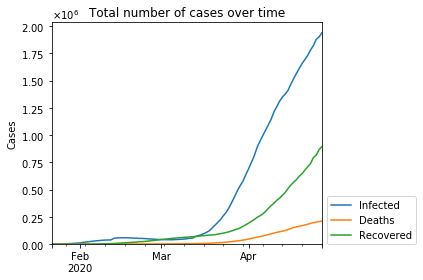

In [227]:
line_plot(total_df[data_cols], "Total number of cases over time")

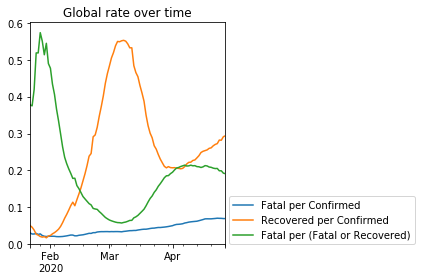

In [228]:
line_plot(total_df[rate_cols], "Global rate over time", ylabel="", math_scale=False)

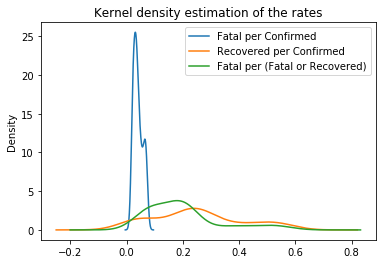

In [229]:
total_df[rate_cols].plot.kde()
plt.title("Kernel density estimation of the rates")
plt.show()

In [230]:
total_df[rate_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Fatal per Confirmed,97.0,0.040774,0.015933,0.020408,0.027630,0.035941,0.053642,0.070456
Recovered per Confirmed,97.0,0.251489,0.157551,0.017365,0.136096,0.238546,0.321137,0.552602
Fatal per (Fatal or Recovered),97.0,0.197878,0.129804,0.057464,0.095465,0.191078,0.212391,0.573427


# GROWTH FACTOR ANALYSIS

In [231]:
linelist_open_raw = pd.read_csv("/Users/kulbir/desktop/covid19/input/novel-corona-virus-2019-dataset/COVID19_open_line_list.csv")
linelist_open_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14126 entries, 0 to 14125
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        13173 non-null  float64
 1   age                       1349 non-null   object 
 2   sex                       1264 non-null   object 
 3   city                      10194 non-null  object 
 4   province                  12906 non-null  object 
 5   country                   13148 non-null  object 
 6   wuhan(0)_not_wuhan(1)     13170 non-null  float64
 7   latitude                  13147 non-null  float64
 8   longitude                 13147 non-null  float64
 9   geo_resolution            13147 non-null  object 
 10  date_onset_symptoms       746 non-null    object 
 11  date_admission_hospital   730 non-null    object 
 12  date_confirmation         13089 non-null  object 
 13  symptoms                  493 non-null    object 
 14  lives_

In [232]:
df = ncov_df_ungrouped.pivot_table(
    index="Date", columns="Country", values="Confirmed", aggfunc="sum"
).fillna(method="ffill").fillna(0)
# Growth factor: (delta Number_n) / (delta Number_n)
df = df.diff() / df.diff().shift(freq="D")
df = df.replace(np.inf, np.nan).fillna(1.0)
# Rolling mean (window: 7 days)
df = df.rolling(7).mean().dropna().loc[:ncov_df_ungrouped["Date"].max(), :]
# round: 0.01
growth_value_df = df.round(2)
growth_value_df.tail()

Country,Azerbaijan,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Aruba,...,Uzbekistan,Vatican City,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Yemen,Zambia,Zimbabwe,occupied Palestinian territory
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-23,1.0,1.30,1.10,1.00,0.56,0.71,0.86,1.22,1.02,1.0,...,1.01,1.0,1.58,0.86,0.86,1.0,1.0,0.94,0.71,1.0
2020-04-24,1.0,1.23,1.05,0.98,0.56,0.71,0.86,1.20,1.11,1.0,...,1.00,1.0,1.62,1.00,0.81,1.0,1.0,1.37,0.71,1.0
2020-04-25,1.0,1.39,1.32,1.02,0.63,0.71,0.86,1.21,1.11,1.0,...,0.96,1.0,1.58,0.86,-4.34,1.0,1.0,1.19,0.86,1.0
2020-04-26,1.0,1.15,1.15,1.04,0.47,0.86,0.86,1.17,1.10,1.0,...,0.85,1.0,1.46,0.86,-4.51,1.0,1.0,1.22,0.86,1.0
2020-04-27,1.0,1.44,1.03,1.06,0.55,0.86,0.86,1.14,1.07,1.0,...,1.45,1.0,1.74,0.86,-4.46,1.0,1.0,1.08,0.86,1.0


In [233]:
df = growth_value_df.copy()
df = df.iloc[-7:, :].T
day_cols = df.columns.strftime("%d%b%Y")
df.columns = day_cols
last_date = day_cols[-1]
# Grouping
more_col, less_col = "GF > 1 [straight days]", "GF < 1 [straight days]"
df[more_col] = (growth_value_df > 1).iloc[::-1].cumprod().sum(axis=0)
df[less_col] = (growth_value_df < 1).iloc[::-1].cumprod().sum(axis=0)
df["Group"] = df[[more_col, less_col]].apply(
    lambda x: "Outbreaking" if x[0] >= 7 else "Stopping" if x[1] >= 7 else "Crossroad",
    axis=1
)
# Sorting
df = df.loc[:, ["Group", more_col, less_col, *day_cols]]
df = df.sort_values(["Group", more_col, less_col], ascending=False)
growth_df = df.copy()
growth_df.head()

Date,Group,GF > 1 [straight days],GF < 1 [straight days],21Apr2020,22Apr2020,23Apr2020,24Apr2020,25Apr2020,26Apr2020,27Apr2020
Country,,,,,,,,,,
Chad,Stopping,0,33,0.71,0.71,0.71,0.86,0.84,0.84,0.84
Equatorial Guinea,Stopping,0,33,0.64,0.61,0.61,0.61,0.66,0.51,0.51
Nicaragua,Stopping,0,33,0.86,0.86,0.86,0.71,0.71,0.71,0.71
Saint Kitts and Nevis,Stopping,0,33,0.71,0.86,0.86,0.86,0.86,0.86,0.86
Syria,Stopping,0,33,0.57,0.43,0.57,0.57,0.71,0.71,0.71


In [234]:
df = pd.merge(ncov_df_ungrouped, growth_df["Group"].reset_index(), on="Country")
ncov_df = df.loc[:, ["Date", "Group", *ncov_df_ungrouped.columns[1:]]]
ncov_df.tail()

,Date,Group,Country,Province,Confirmed,Infected,Deaths,Recovered
19281,2020-04-23,Crossroad,Yemen,-,1,1,0,0
19282,2020-04-24,Crossroad,Yemen,-,1,0,0,1
19283,2020-04-25,Crossroad,Yemen,-,1,0,0,1
19284,2020-04-26,Crossroad,Yemen,-,1,0,0,1
19285,2020-04-27,Crossroad,Yemen,-,1,0,0,1


In [235]:
df = growth_df.loc[growth_df["Group"] == "Outbreaking", :]
", ".join(df.index.tolist()) + "."

'Mexico, Bahrain, Bulgaria, Estonia, Guatemala, Honduras, India, Latvia, Peru, Qatar, Russia, Senegal, Afghanistan, Brazil, Kenya, Saudi Arabia, Bangladesh, Slovakia, Armenia, Mali, Albania, Burma, Congo, Ecuador, Dominican Republic, Egypt, El Salvador, South Africa, Montenegro, Pakistan, Rwanda, Cabo Verde, Luxembourg, Norway, Kuwait, San Marino, Jordan, Sierra Leone, Maldives, Azerbaijan, Hungary, Mozambique, Spain, Burkina Faso, Gabon, Jamaica, Malta, Panama, Costa Rica, Croatia, Greece, Indonesia, Ukraine.'

In [236]:
growth_df.loc[growth_df["Group"] == "Outbreaking", :].head()

Date,Group,GF > 1 [straight days],GF < 1 [straight days],21Apr2020,22Apr2020,23Apr2020,24Apr2020,25Apr2020,26Apr2020,27Apr2020
Country,,,,,,,,,,
Mexico,Outbreaking,39,0,1.07,1.12,1.37,1.31,1.24,1.21,1.18
Bahrain,Outbreaking,33,0,1.33,1.33,1.80,1.83,1.74,1.40,1.55
Bulgaria,Outbreaking,33,0,1.19,1.17,1.16,1.30,1.22,1.73,1.59
Estonia,Outbreaking,33,0,1.13,1.10,1.59,1.54,1.57,1.57,1.57
Guatemala,Outbreaking,33,0,1.05,1.51,1.78,1.71,1.68,1.62,1.57


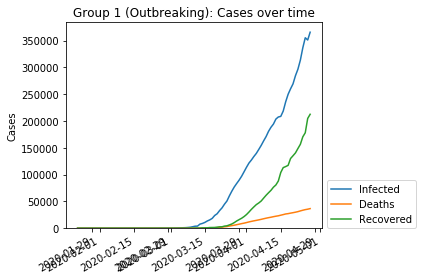

,Infected,Deaths,Recovered
Date,,,
2020-04-23,313477,32271,156482
2020-04-24,336488,33516,170414
2020-04-25,355223,34637,178016
2020-04-26,351029,35462,204752
2020-04-27,365587,36559,212496


In [237]:
df = ncov_df.loc[ncov_df["Group"] == "Outbreaking", ["Date", *data_cols]].groupby("Date").sum()
line_plot(df, "Group 1 (Outbreaking): Cases over time", y_integer=True)
df.tail()

In [238]:
df = growth_df.loc[growth_df["Group"] == "Stopping", :]
", ".join(df.index.tolist()) + "."

'Chad, Equatorial Guinea, Nicaragua, Saint Kitts and Nevis, Syria, Zimbabwe, Botswana, Fiji, Trinidad and Tobago, Cameroon, Andorra, Hong Kong, Nepal, Central African Republic, Iran, Papua New Guinea, Angola, Ghana, West Bank and Gaza, Djibouti, Liberia, Liechtenstein, Serbia, Benin, Holy See, Libya, Nigeria.'

In [239]:
growth_df.loc[growth_df["Group"] == "Stopping", :].head()

Date,Group,GF > 1 [straight days],GF < 1 [straight days],21Apr2020,22Apr2020,23Apr2020,24Apr2020,25Apr2020,26Apr2020,27Apr2020
Country,,,,,,,,,,
Chad,Stopping,0,33,0.71,0.71,0.71,0.86,0.84,0.84,0.84
Equatorial Guinea,Stopping,0,33,0.64,0.61,0.61,0.61,0.66,0.51,0.51
Nicaragua,Stopping,0,33,0.86,0.86,0.86,0.71,0.71,0.71,0.71
Saint Kitts and Nevis,Stopping,0,33,0.71,0.86,0.86,0.86,0.86,0.86,0.86
Syria,Stopping,0,33,0.57,0.43,0.57,0.57,0.71,0.71,0.71


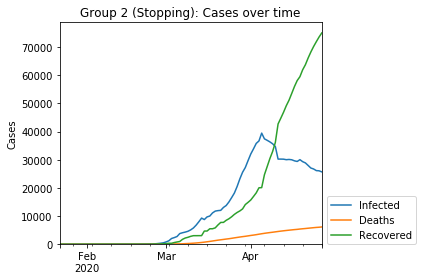

,Infected,Deaths,Recovered
Date,,,
2020-04-23,27064,5770,68285
2020-04-24,26721,5868,70214
2020-04-25,26146,5958,71940
2020-04-26,26077,6028,73596
2020-04-27,25691,6126,75043


In [240]:
df = ncov_df.loc[ncov_df["Group"] == "Stopping", ["Date", *data_cols]].groupby("Date").sum()
line_plot(df, "Group 2 (Stopping): Cases over time", y_integer=True)
df.tail()

In [241]:
df = growth_df.loc[growth_df["Group"] == "Crossroad", :]
", ".join(df.index.tolist()) + "."

'Chile, Israel, Malawi, Moldova, North Macedonia, Sri Lanka, Uganda, Argentina, Bolivia, Philippines, Uruguay, Venezuela, Cyprus, Eswatini, Georgia, Thailand, Zambia, Algeria, Austria, Bahamas, Bosnia and Herzegovina, Canada, Denmark, Ethiopia, Iceland, Iraq, Slovenia, Finland, Ireland, Niger, Romania, South Korea, China, Colombia, France, Guinea-Bissau, Japan, Madagascar, Malaysia, Mauritius, Tunisia, Uzbekistan, Bhutan, Turkey, Antigua and Barbuda, Burundi, Grenada, Netherlands, Paraguay, Saint Vincent and the Grenadines, Australia, Cuba, Somalia, South Sudan, Tanzania, Italy, Ivory Coast, Lithuania, Mongolia, Sudan, Timor-Leste, UK, Vietnam, Belgium, Czech Republic, Guinea, New Zealand, Switzerland, Taiwan, Germany, Haiti, Kazakhstan, Lebanon, Morocco, Oman, Portugal, Singapore, Sweden, Togo, US,  Azerbaijan, Aruba, Bahamas, The, Barbados, Belarus, Belize, Brunei, Cambodia, Cape Verde, Cayman Islands, Channel Islands, Curacao, Dominica, East Timor, Eritrea, Faroe Islands, French Gui

In [242]:
growth_df.loc[growth_df["Group"] == "Crossroad", :].head()

Date,Group,GF > 1 [straight days],GF < 1 [straight days],21Apr2020,22Apr2020,23Apr2020,24Apr2020,25Apr2020,26Apr2020,27Apr2020
Country,,,,,,,,,,
Chile,Crossroad,6,0,1.00,1.08,1.02,1.04,1.04,1.06,1.04
Israel,Crossroad,6,0,0.93,1.13,1.13,1.13,1.08,1.05,1.02
Malawi,Crossroad,6,0,0.86,1.43,1.57,1.43,1.57,1.57,1.71
Moldova,Crossroad,6,0,0.86,1.14,1.14,1.17,1.17,1.13,1.11
North Macedonia,Crossroad,6,0,0.88,1.37,1.35,1.39,1.41,1.38,1.40


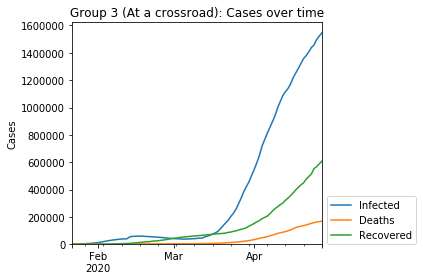

,Infected,Deaths,Recovered
Date,,,
2020-04-23,1439000,152817,513719
2020-04-24,1456935,157767,552792
2020-04-25,1495846,162251,566729
2020-04-26,1522092,165054,587385
2020-04-27,1545352,168482,606428


In [243]:
df = ncov_df.loc[ncov_df["Group"] == "Crossroad", ["Date", *data_cols]].groupby("Date").sum()
line_plot(df, "Group 3 (At a crossroad): Cases over time", y_integer=True)
df.tail()

# Example SIR Model Run

In [244]:
eg_r0, eg_rho = (2.5, 0.2)
eg_sigma = eg_rho / eg_r0
eg_initials = (0.999, 0.001, 0)
display(Markdown(rf"$\rho = {eg_rho},\ \sigma = {eg_sigma}$."))

$\rho = 0.2,\ \sigma = 0.08$.

In [245]:
%%time
eg_df = simulation(SIR, eg_initials, step_n=180, rho=eg_rho, sigma=eg_sigma)
eg_df.tail()

CPU times: user 10 ms, sys: 3.91 ms, total: 13.9 ms
Wall time: 11.6 ms


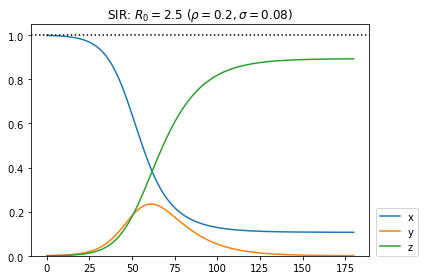

In [246]:
line_plot(
    eg_df.set_index("t"),
    title=r"SIR: $R_0={0}\ (\rho={1}, \sigma={2})$".format(eg_r0, eg_rho, eg_sigma),
    ylabel="",
    h=1
)

In [247]:
x_max = eg_df.loc[eg_df["y"].idxmax(), "x"]
(x_max, 1/eg_r0)

(0.39661788452227087, 0.4)

In [248]:
eg_tau = 1440
eg_start_date = ncov_df["Date"].min()
eg_total_population = 1_000_000
print(f"The start date is {eg_start_date.strftime('%d%b%Y')}.")

The start date is 22Jan2020.


In [249]:
eg_ori_df = pd.DataFrame(
    {
        "Date": (eg_df["t"] * eg_tau).apply(lambda x: timedelta(minutes=x)) + eg_start_date,
        "Group": "Stopping",
        "Country": "Example",
        "Province": "-",
        "Susceptible": 0,
        "Confirmed": 0,
        "Infected": (eg_df["y"] * eg_total_population).astype(np.int64)
    }
)
eg_ori_df["Recovered + Deaths"] = (eg_df["z"] * eg_total_population).astype(np.int64)
eg_ori_df ["Confirmed"] = eg_ori_df[["Infected", "Recovered + Deaths"]].sum(axis=1)
eg_ori_df["Susceptible"] = eg_total_population - eg_ori_df["Confirmed"]
eg_ori_df.tail()

,Date,Group,Country,Province,Susceptible,Confirmed,Infected,Recovered + Deaths
176,2020-07-16,Stopping,Example,-,106644,893356,659,892697
177,2020-07-17,Stopping,Example,-,106631,893369,621,892748
178,2020-07-18,Stopping,Example,-,106617,893383,586,892797
179,2020-07-19,Stopping,Example,-,106606,893394,552,892842
180,2020-07-20,Stopping,Example,-,106594,893406,521,892885


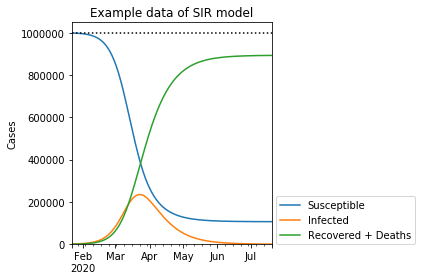

In [250]:
line_plot(
    eg_ori_df.set_index("Date")[["Susceptible", "Infected", "Recovered + Deaths"]],
    "Example data of SIR model",
    h=eg_total_population,
    y_integer=True
)

# Example SIRD Model Run

In [251]:
eg_r0, eg_kappa, eg_rho = (2.5, 0.005, 0.2)
eg_sigma = eg_rho / eg_r0 - eg_kappa
eg_initials = (0.999, 0.001, 0, 0)
display(Markdown(rf"$\kappa = {eg_kappa},\ \rho = {eg_rho},\ \sigma = {eg_sigma}$."))

$\kappa = 0.005,\ \rho = 0.2,\ \sigma = 0.075$.

In [252]:
%%time
eg_df = simulation(SIRD, eg_initials, step_n=180, kappa=eg_kappa, rho=eg_rho, sigma=eg_sigma)
eg_df.tail()

CPU times: user 17.2 ms, sys: 5.41 ms, total: 22.6 ms
Wall time: 15.4 ms


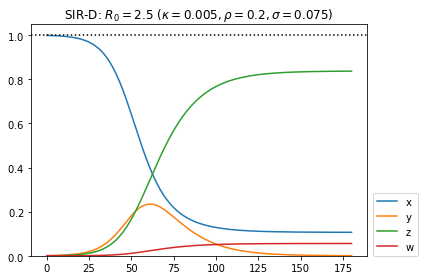

In [253]:
line_plot(
    eg_df.set_index("t"),
    title=r"SIR-D: $R_0={0}\ (\kappa={1}, \rho={2}, \sigma={3})$".format(eg_r0, eg_kappa, eg_rho, eg_sigma),
    ylabel="",
    h=1
)

In [254]:
x_max = eg_df.loc[eg_df["y"].idxmax(), "x"]
(x_max, 1/eg_r0)

(0.3968570016512388, 0.4)

In [255]:
eg_tau = 1440
eg_start_date = ncov_df["Date"].min()
eg_total_population = 1_000_000
print(f"The start date is {eg_start_date.strftime('%d%b%Y')}.")

The start date is 22Jan2020.


In [256]:
eg_ori_df = pd.DataFrame(
    {
        "Date": (eg_df["t"] * eg_tau).apply(lambda x: timedelta(minutes=x)) + eg_start_date,
        "Group": "Stopping",
        "Country": "Example",
        "Province": "-",
        "Susceptible": 0,
        "Confirmed": 0,
        "Infected": (eg_df["y"] * eg_total_population).astype(np.int64)
    }
)
eg_ori_df["Recovered"] = (eg_df["z"] * eg_total_population).astype(np.int64)
eg_ori_df["Deaths"] = (eg_df["w"] * eg_total_population).astype(np.int64)
eg_ori_df["Confirmed"] = eg_ori_df[["Infected", "Recovered", "Deaths"]].sum(axis=1)
eg_ori_df["Susceptible"] = eg_total_population - eg_ori_df["Confirmed"]
eg_ori_df.tail()

,Date,Group,Country,Province,Susceptible,Confirmed,Infected,Recovered,Deaths
176,2020-07-16,Stopping,Example,-,106630,893370,660,836916,55794
177,2020-07-17,Stopping,Example,-,106617,893383,622,836964,55797
178,2020-07-18,Stopping,Example,-,106604,893396,587,837009,55800
179,2020-07-19,Stopping,Example,-,106592,893408,553,837052,55803
180,2020-07-20,Stopping,Example,-,106580,893420,522,837092,55806


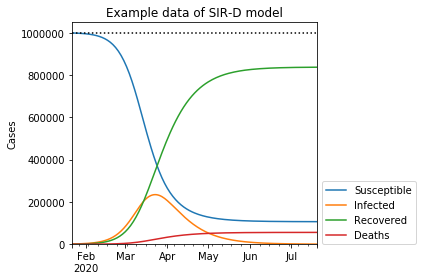

In [257]:
line_plot(
    eg_ori_df.set_index("Date")[["Susceptible", "Infected", "Recovered", "Deaths"]],
    "Example data of SIR-D model",
    h=eg_total_population,
    y_integer=True
)

# Example SIRF Model Run

In [258]:
eg_r0, eg_theta, eg_kappa, eg_rho = (2.5, 0.002, 0.005, 0.2)
eg_sigma = eg_rho / eg_r0 - eg_kappa
eg_initials = (0.999, 0.001, 0, 0)
display(Markdown(rf"$\theta = {eg_theta},\ \kappa = {eg_kappa},\ \rho = {eg_rho},\ \sigma = {eg_sigma}$."))

$\theta = 0.002,\ \kappa = 0.005,\ \rho = 0.2,\ \sigma = 0.075$.

In [259]:
%%time
eg_df = simulation(SIRF, eg_initials, step_n=180, theta=eg_theta, kappa=eg_kappa, rho=eg_rho, sigma=eg_sigma)
eg_df.tail()

CPU times: user 18.9 ms, sys: 4.84 ms, total: 23.7 ms
Wall time: 13.2 ms


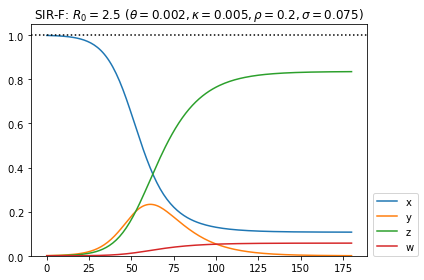

In [260]:
line_plot(
    eg_df.set_index("t"),
    title=r"SIR-F: $R_0={0}\ (\theta={1}, \kappa={2}, \rho={3}, \sigma={4})$".format(
        eg_r0, eg_theta, eg_kappa, eg_rho, eg_sigma
    ),
    ylabel="",
    h=1
)

In [261]:
x_max = eg_df.loc[eg_df["y"].idxmax(), "x"]
(x_max, 1/eg_r0)

(0.4004978349791952, 0.4)

There is an inflection point of y (the number of currentry infected cases per total population). At this point, value of x (the number of susceptible cases per total population) is nearly equal to  1𝑅0
1/Ro


# Scenario In Italy

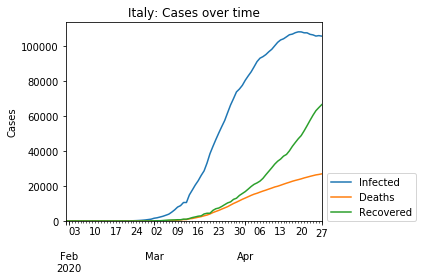

,Date,Confirmed,Infected,Deaths,Recovered
83,2020-04-23,189973,106848,25549,57576
84,2020-04-24,192994,106527,25969,60498
85,2020-04-25,195351,105847,26384,63120
86,2020-04-26,197675,106103,26644,64928
87,2020-04-27,199414,105813,26977,66624


In [262]:
ita_scenario = Scenario(ncov_df, name="Italy", population_dict=population_dict)
ita_scenario.show_record().tail()

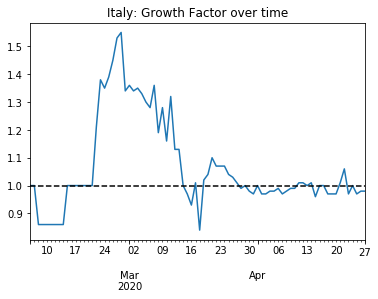

,Date,Group,GF > 1 [straight days],GF < 1 [straight days]
Italy,2020-04-27,Crossroad,0,3


In [263]:
ita_scenario.growth_factor()

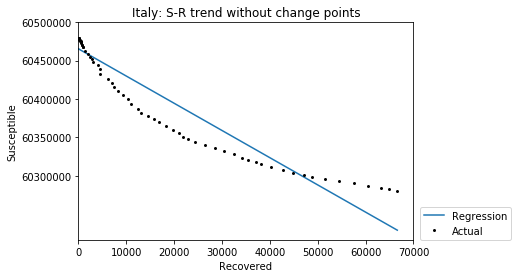

In [264]:
_ = ita_scenario.trend()

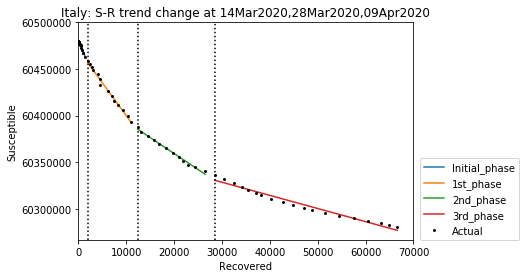

In [265]:
ita_change_points = ita_scenario.trend(n_points=3)

In [266]:
ita_scenario.set_phase(start_dates=ita_change_points)

,start_date,end_date,population
1st,14Mar2020,27Mar2020,60480000
2nd,28Mar2020,08Apr2020,60480000
3rd,09Apr2020,-,60480000


In [267]:
ita_scenario.estimate(SIRF)

Hyperparameter estimation of 1st phase.
	Estimator was created.
		100 trials finished in 0 min 14 sec.
		100 trials finished in 0 min 17 sec.
	Successfully estimated.
Hyperparameter estimation of 2nd phase.
	Estimator was created.
		100 trials finished in 0 min 13 sec.
	Successfully estimated.
Hyperparameter estimation of 3rd phase.
	Estimator was created.
		100 trials finished in 0 min 13 sec.
	Successfully estimated.
Total: 0 min 58 sec.


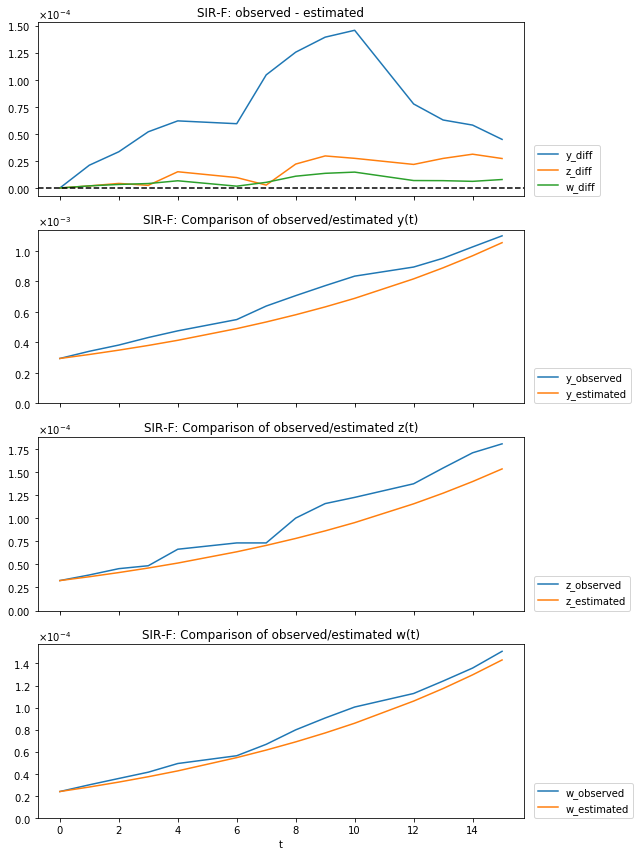

In [268]:
ita_scenario.accuracy_graph(phase_n=1)

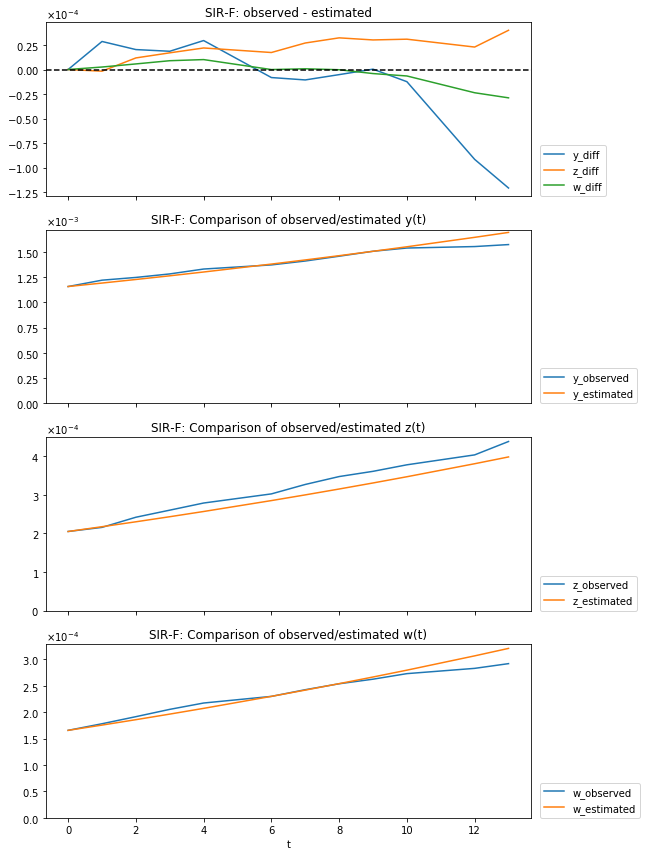

In [269]:
ita_scenario.accuracy_graph(phase_n=2)

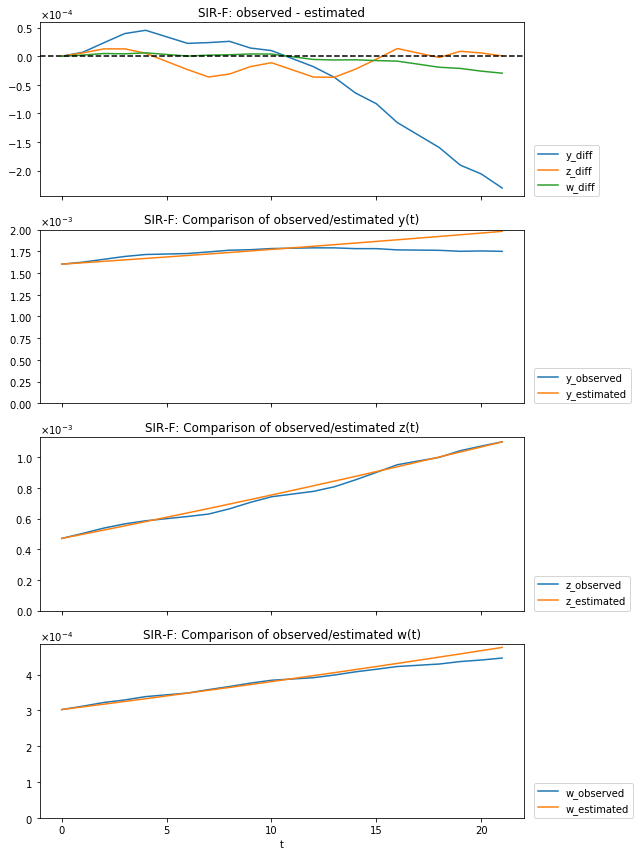

In [270]:
ita_scenario.accuracy_graph(phase_n=3)

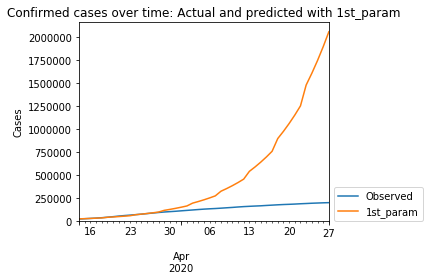

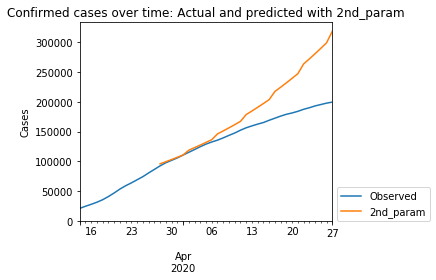

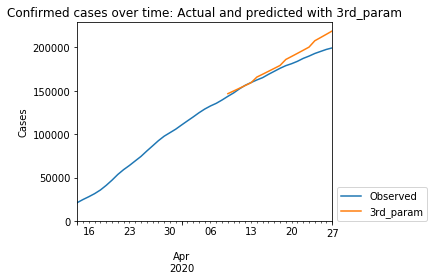

In [271]:
ita_scenario.compare_estimated_numbers(phases=["1st", "2nd", "3rd"])

In [272]:
ita_scenario.show_parameters()

,start_date,end_date,population,tau,theta,kappa,rho,sigma,Rt,score,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day]
1st,14Mar2020,27Mar2020,60480000,1200,0.092800,0.002973,0.112248,0.013599,6.14,0.148116,0.093,280,7,61
2nd,28Mar2020,08Apr2020,60480000,1200,0.167516,0.000375,0.048423,0.010541,3.69,0.054325,0.168,2220,17,79
3rd,09Apr2020,-,60480000,1200,0.122867,0.000755,0.031641,0.016820,1.58,0.040849,0.123,1103,26,49


# Scenario in INDIA

In [82]:
ind_scenario = Scenario(ncov_df, name="India", population_dict=population_dict)

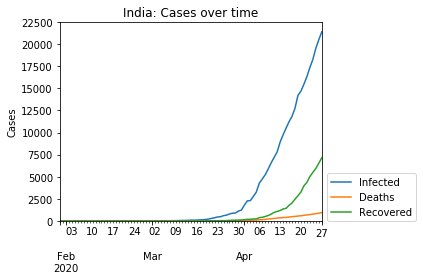

,Date,Confirmed,Infected,Deaths,Recovered
84,2020-04-23,23077,17344,721,5012
85,2020-04-24,24530,18252,780,5498
86,2020-04-25,26283,19519,825,5939
87,2020-04-26,27890,20486,881,6523
88,2020-04-27,29451,21375,939,7137


In [83]:
ind_scenario.show_record().tail()

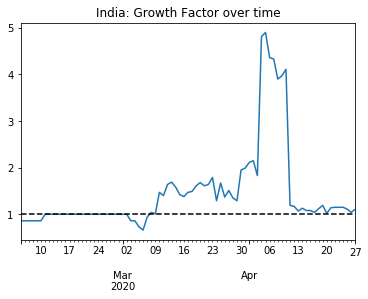

,Date,Group,GF > 1 [straight days],GF < 1 [straight days]
India,2020-04-27,Outbreaking,51,0


In [84]:
ind_scenario.growth_factor()

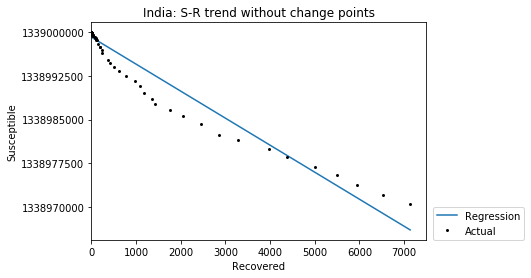

In [85]:
_ = ind_scenario.trend()

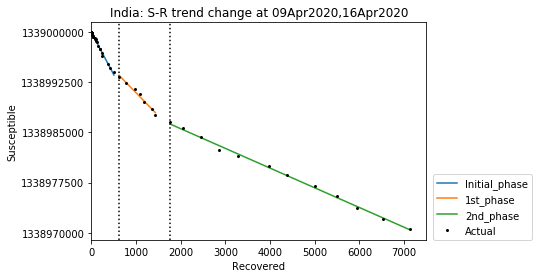

In [86]:
ind_change_points = ind_scenario.trend(n_points=2)

In [87]:
ind_scenario.set_phase(start_dates=ind_change_points)

,start_date,end_date,population
1st,09Apr2020,15Apr2020,1339000000
2nd,16Apr2020,-,1339000000


In [88]:
ind_scenario.estimate(SIRF)

Hyperparameter estimation of 1st phase.
	Estimator was created.
		100 trials finished in 0 min 13 sec.
		100 trials finished in 0 min 17 sec.
		100 trials finished in 0 min 17 sec.
		100 trials finished in 0 min 19 sec.
		100 trials finished in 0 min 21 sec.
	Successfully estimated.
Hyperparameter estimation of 2nd phase.
	Estimator was created.
		100 trials finished in 0 min 12 sec.
		100 trials finished in 0 min 13 sec.
	Successfully estimated.
Total: 1 min 56 sec.


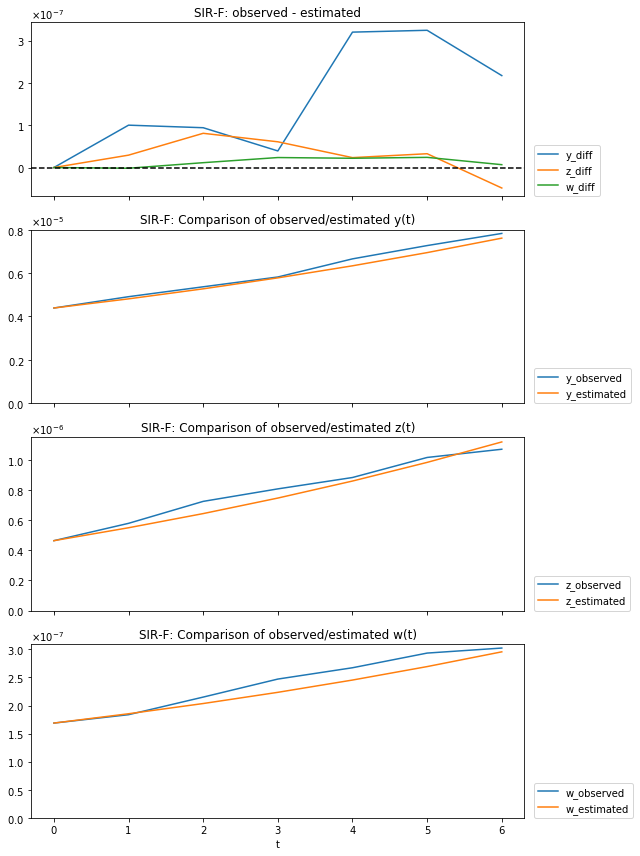

In [89]:
ind_scenario.accuracy_graph(phase_n=1)

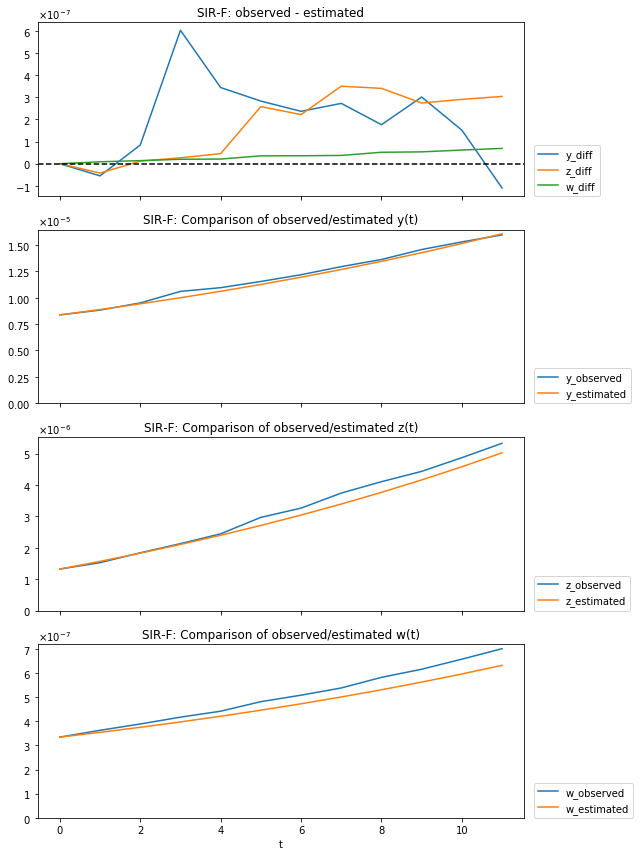

In [90]:
ind_scenario.accuracy_graph(phase_n=2)

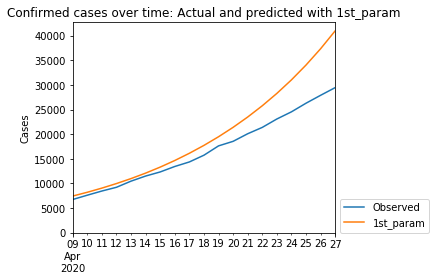

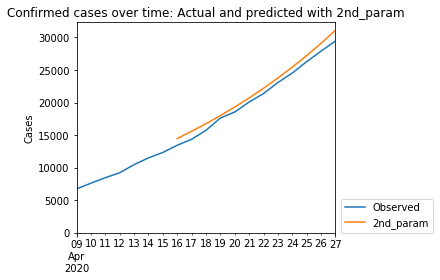

In [91]:
ind_scenario.compare_estimated_numbers(phases=["1st", "2nd"])

In [92]:
ind_scenario.show_parameters()

,start_date,end_date,population,tau,theta,kappa,rho,sigma,Rt,score,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day]
1st,09Apr2020,15Apr2020,1339000000,1404,0.020438,0.001284,0.113989,0.018642,5.60,0.057279,0.020,759,8,52
2nd,16Apr2020,-,1339000000,1404,0.021594,0.000346,0.090090,0.028532,3.05,0.058634,0.022,2814,10,34


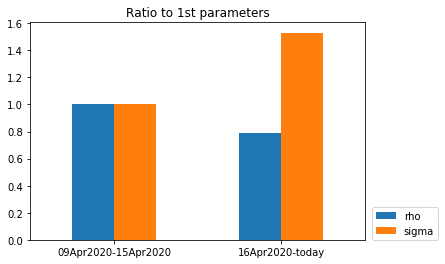

In [93]:
ind_scenario.param_history(["rho", "sigma"])

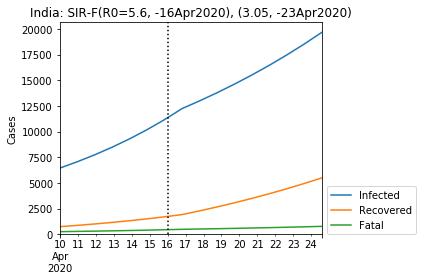

,Susceptible,Infected,Recovered,Fatal,Confirmed
Time,,,,,
2020-04-18 18:00:00,1338983019,13787,2655,536,16978
2020-04-19 17:24:00,1338981740,14629,3061,568,18258
2020-04-20 16:48:00,1338980382,15522,3491,603,19616
2020-04-21 16:12:00,1338978941,16470,3947,640,21057
2020-04-22 15:36:00,1338977413,17476,4431,679,22586
2020-04-23 15:00:00,1338975791,18543,4945,720,24208
2020-04-24 14:24:00,1338974070,19675,5490,764,25929


In [94]:
ind_scenario.predict(days=7).tail(7).style.background_gradient(axis=0)

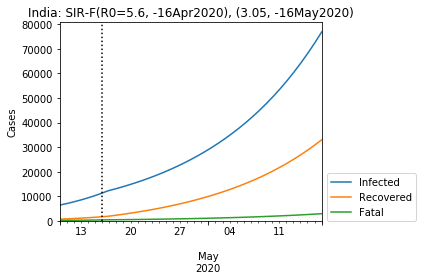

,Susceptible,Infected,Recovered,Fatal,Confirmed
Time,,,,,
2020-05-11 04:12:00,1338922138,53837,21938,2085,77860
2020-05-12 03:36:00,1338917131,57131,23524,2212,82867
2020-05-13 03:00:00,1338911816,60628,25207,2347,88182
2020-05-14 02:24:00,1338906176,64338,26993,2491,93822
2020-05-15 01:48:00,1338900193,68274,28888,2643,99805
2020-05-16 01:12:00,1338893847,72448,30898,2805,106151
2020-05-17 00:36:00,1338887120,76873,33029,2976,112878


In [95]:
ind_scenario.predict(days=30).tail(7).style.background_gradient(axis=0)

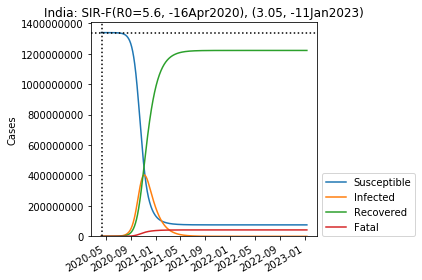

In [96]:
_ = ind_scenario.predict(days=1000, min_infected=1)